# 자전거 대여 데이터

- 2011년부터 2012년까지 2년간의 자전거 대여 데이터
- 캐피털 바이크셰어 회사가 공개한 운행 기록에 다양한 외부 소스에서 얻은 당시 날씨 정보를 조합
- 한 시간 간격으로 기록됨
- 훈련 데이터 : 매달 1일부터 19일까지의 기록
- 테스트 데이터 : 매달 20일부터 월말까지의 기록
- 피처
    - datatime : 기록 일시(1시간 간격)
    - season : 계절
        
        - 1 : 봄(1분기)
        - 2 : 여름(2분기)
        - 3 : 가을(3분기)
        - 4 : 겨울(4분기)
        - 공식 문서에는 계절로 설명하고 있지만 실제로는 분기로 나누어져 있음
    - holiday : 공휴일 여부(0 : 공휴일 아님, 1 : 공휴일)
    - workingday : 근무일 여부(0 : 근무일 아님, 1 : 근무일)
        - 주말과 공휴일이 아니면 근무일이라고 간주
    - weahther : 날씨
        - 1 : 맑음
        - 2 : 옅은 안개, 약간 흐림
        - 3 : 약간의 눈, 약간의 비와 천둥 번개, 흐림
        - 4 : 폭우와 천둥 번개, 눈과 짙은 안개
        - 숫자가 클수록 날씨가 안 좋음
    - temp : 실제 온도
    - atemp : 체감 온도
    - humidity : 상대 습도
    - windspeed : 풍속
    - casual : 등록되지 않은 사용자(비회원) 수
    - registered : 등록된 사용자(회원) 수
    - count : 자전거 대여 수량
- 종속변수 : count
- 평가지표 : RMSLE(Root Mean Squared Logarithmic Error)

- y_true = 정답값, y_pred = 예측값

In [1]:
def rmsle(y_true, y_pred, convertExp = True):
    '''
    실제 타깃값과 예측값을 인수로 전달하면 RMSLE 수치를 반환하는 함수
    convertExp : 입력 데이터를 지수변환할지 정하는 파라미터
    타깃값으로 log(count)를 사용한 경우에는 지수변환을 해줘야 함
    '''
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)

    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true + 1))
    log_pred = np.nan_to_num(np.log(y_pred + 1))

    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))

    return output

In [96]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import calendar
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_log_error, make_scorer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, randint

import warnings
warnings.filterwarnings('ignore')

In [3]:
from matplotlib import font_manager, rc
import matplotlib
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family=font_name)

In [4]:
df_train = pd.read_csv("./data/bike/train.csv", parse_dates=['datetime'])
df_test = pd.read_csv("./data/bike/test.csv", parse_dates=['datetime'])
test = pd.read_csv("./data/bike/test.csv")

# 데이터 확인

### df_train 

In [5]:
 df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
df_train.shape

(10886, 12)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [8]:
# 결측치 확인
df_train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

- 결측치 없음

In [9]:
df_train.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [10]:
df_train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


- humidity : 습도의 min이 0
- windspeed : 풍속의 min이 0

### df_test

In [11]:
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [12]:
df_test.shape

(6493, 9)

In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


In [14]:
df_test.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
dtype: object

In [15]:
df_test.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2012-01-13 09:27:47.765285632,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
min,2011-01-20 00:00:00,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2011-07-22 15:00:00,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,2012-01-20 23:00:00,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,2012-07-20 17:00:00,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,2012-12-31 23:00:00,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600
std,NaN,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151


## datetime 컬럼을 year, month, day, hour, weekday로 변환

In [16]:
df_train['year'] = df_train['datetime'].dt.year
df_train['month'] = df_train['datetime'].dt.month
df_train['day'] = df_train['datetime'].dt.day
df_train['hour'] = df_train['datetime'].dt.hour
df_train['weekday'] = df_train['datetime'].dt.weekday

In [17]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


In [18]:
# datetime 컬럼 제거
df_train = df_train.drop(["datetime"], axis = 1)

In [19]:
df_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


- 0 : 월
- 1 : 화
- 2 : 수
- 3 : 목
- 4 : 금
- 5 : 토
- 6 : 일

In [20]:
df_train.shape

(10886, 16)

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
 11  year        10886 non-null  int32  
 12  month       10886 non-null  int32  
 13  day         10886 non-null  int32  
 14  hour        10886 non-null  int32  
 15  weekday     10886 non-null  int32  
dtypes: float64(3), int32(5), int64(8)
memory usage: 1.1 MB


In [22]:
# "casual", "registered" 제외하고 컬럼 정렬
df_train = df_train[["season", "holiday", "workingday", "weather", "temp", "atemp", "humidity", "windspeed", "year", "month", "day", "hour", "weekday", "count"]]
df_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,weekday,count
0,1,0,0,1,9.84,14.395,81,0.0,2011,1,1,0,5,16
1,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,1,5,40
2,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,2,5,32
3,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,3,5,13
4,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,4,5,1


## datetime 컬럼을 year, month, day, hour, weekday로 변환(df_test)

In [23]:
df_test['year'] = df_test['datetime'].dt.year
df_test['month'] = df_test['datetime'].dt.month
df_test['day'] = df_test['datetime'].dt.day
df_test['hour'] = df_test['datetime'].dt.hour
df_test['weekday'] = df_test['datetime'].dt.weekday

In [24]:
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,weekday
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,3


In [25]:
# datetime 컬럼 제거
df_test = df_test.drop(["datetime"], axis = 1)

In [26]:
df_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,weekday
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,3
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,3
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,3
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,3


In [27]:
df_test.shape

(6493, 13)

In [28]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      6493 non-null   int64  
 1   holiday     6493 non-null   int64  
 2   workingday  6493 non-null   int64  
 3   weather     6493 non-null   int64  
 4   temp        6493 non-null   float64
 5   atemp       6493 non-null   float64
 6   humidity    6493 non-null   int64  
 7   windspeed   6493 non-null   float64
 8   year        6493 non-null   int32  
 9   month       6493 non-null   int32  
 10  day         6493 non-null   int32  
 11  hour        6493 non-null   int32  
 12  weekday     6493 non-null   int32  
dtypes: float64(3), int32(5), int64(5)
memory usage: 532.8 KB


# 데이터 시각화

In [29]:
vis_df = df_train.iloc[:, 1:9]
vis_df.head()

,holiday,workingday,weather,temp,atemp,humidity,windspeed,year
0,0,0,1,9.84,14.395,81,0.0,2011
1,0,0,1,9.02,13.635,80,0.0,2011
2,0,0,1,9.02,13.635,80,0.0,2011
3,0,0,1,9.84,14.395,75,0.0,2011
4,0,0,1,9.84,14.395,75,0.0,2011


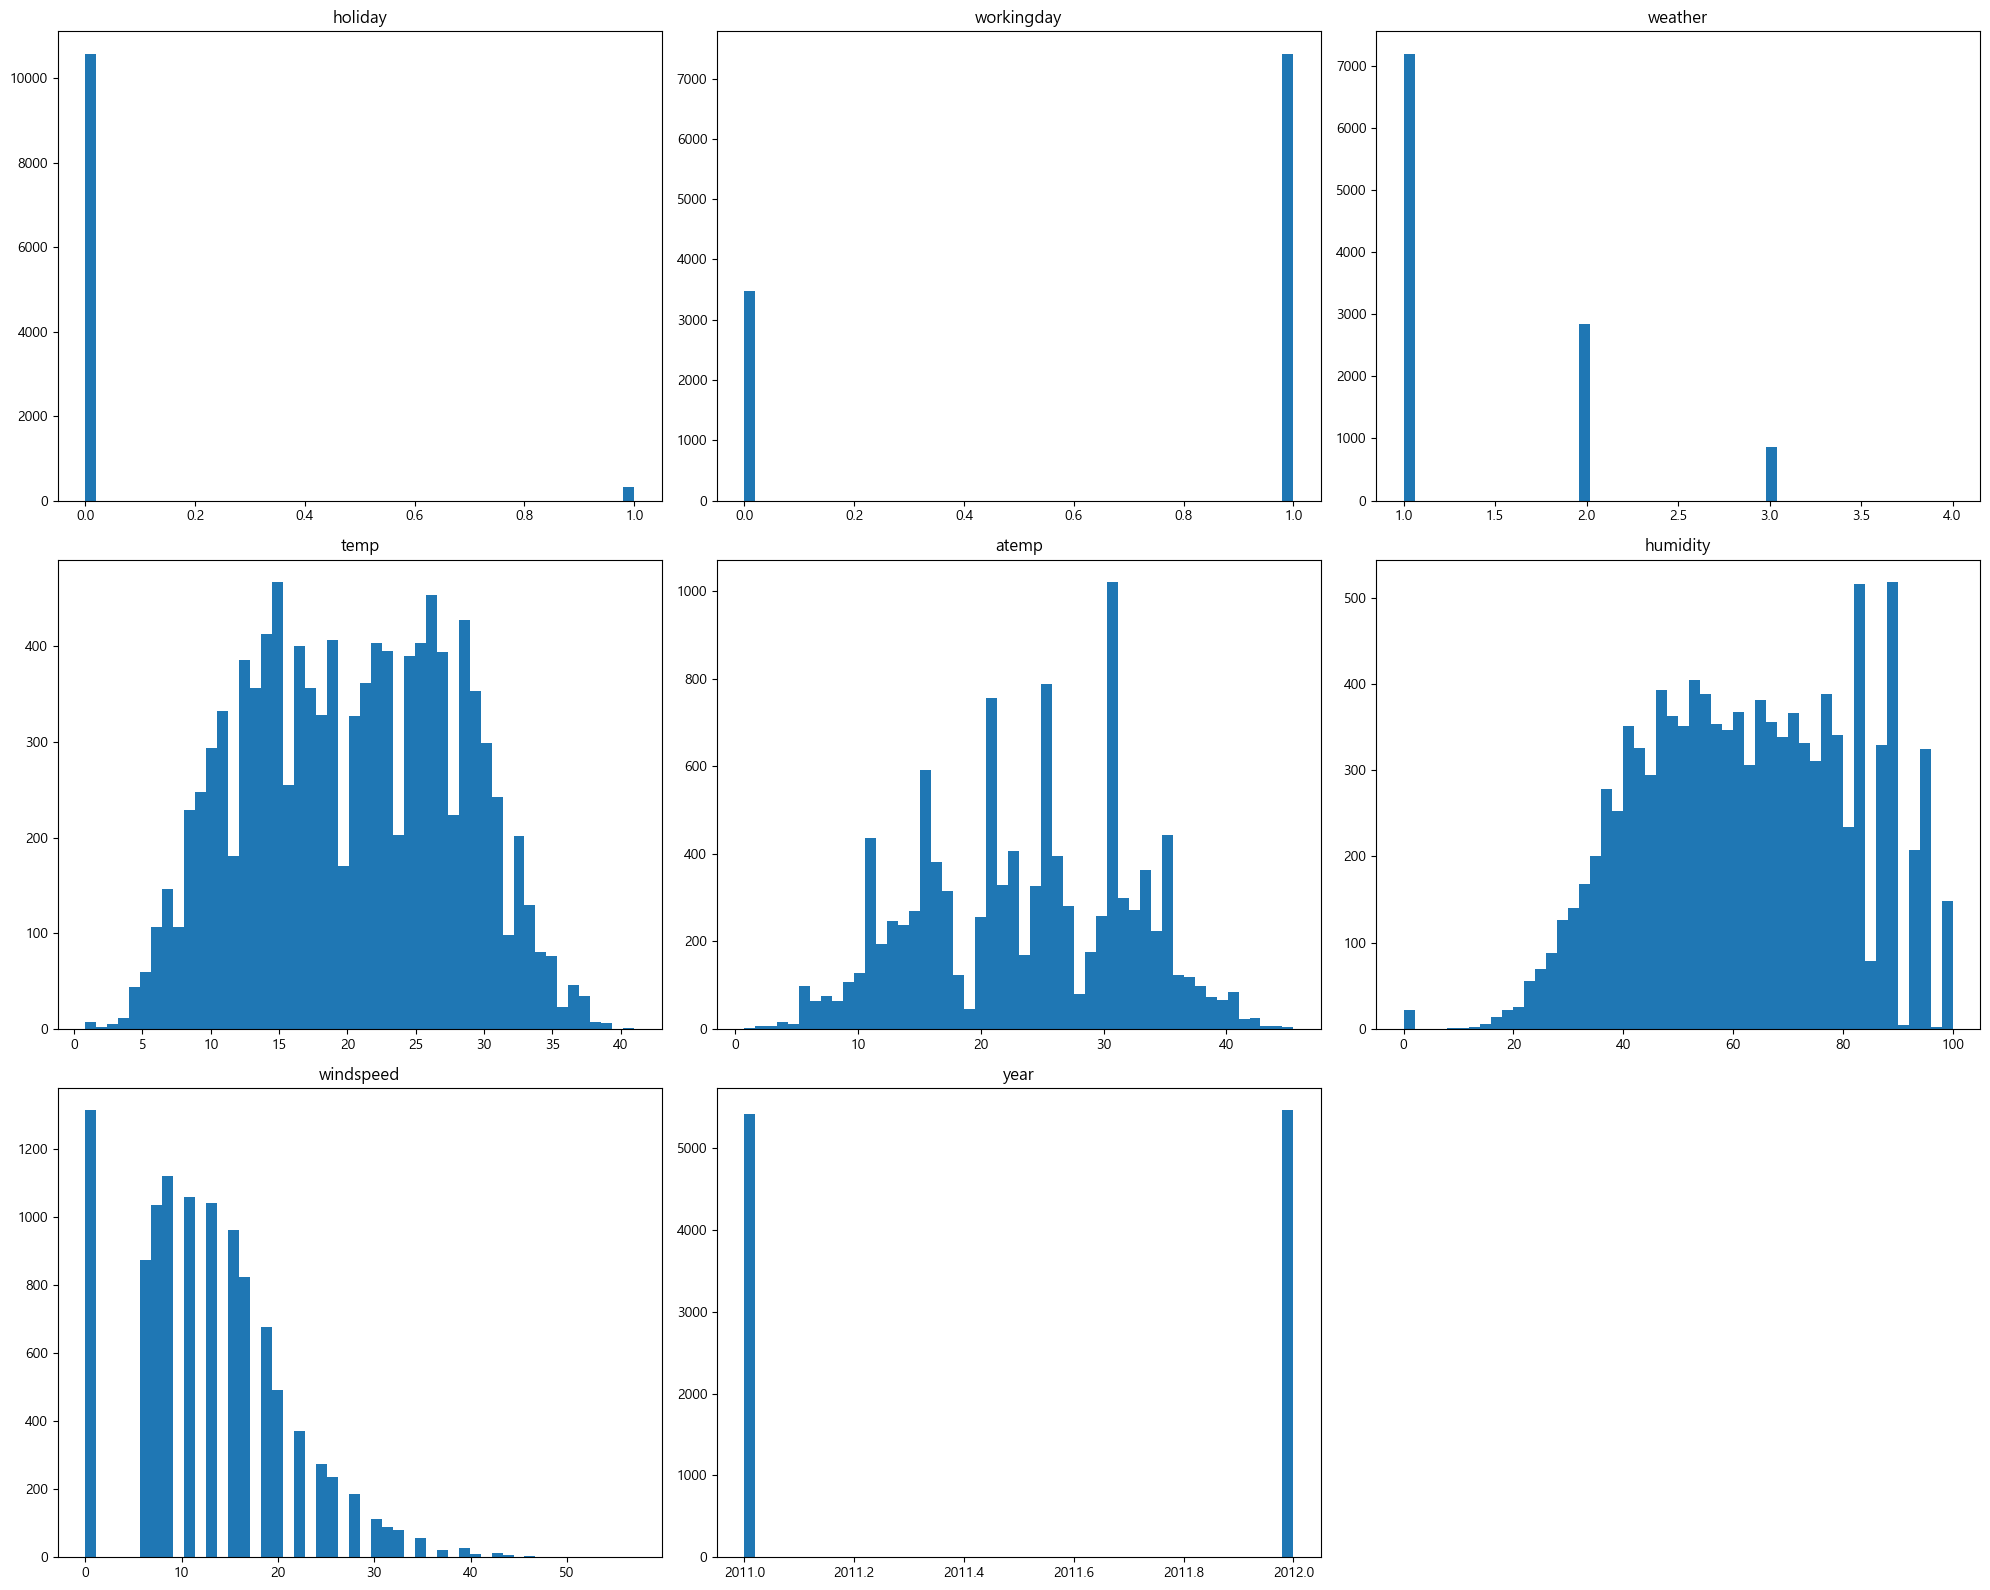

In [30]:
def plot_hist(df):
    plt.rcParams["figure.figsize"] = [20, 16]
    fig = plt.figure(1) # 해당 피규어에 id를 매겨주는 것
    
    # df의 열 개수 만큼의 subplot을 출력
    for i in range(len(df.columns)):
        ax = fig.add_subplot(3, 3, i + 1)
        plt.hist(df[df.columns[i]], bins = 50)
        ax.set_title(df.columns[i])
        
    plt.tight_layout()
    plt.show()
    
plot_hist(vis_df)

### 'count' 컬럼 확인해 보기

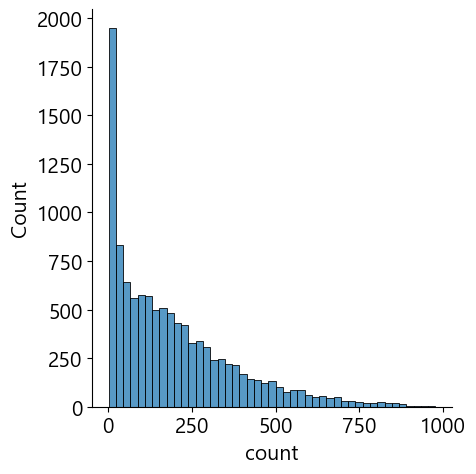

In [31]:
# 분포도 확인해보기
mpl.rc('font', size = 15)
sns.displot(df_train["count"])

- count 값이 0 근처에 몰려 있는 것을 확인할 수 있음
- 종속변수인 count가 정규분포를 따르지 않은 것을 확인할 수 있음
- 로그변환을 진행하기

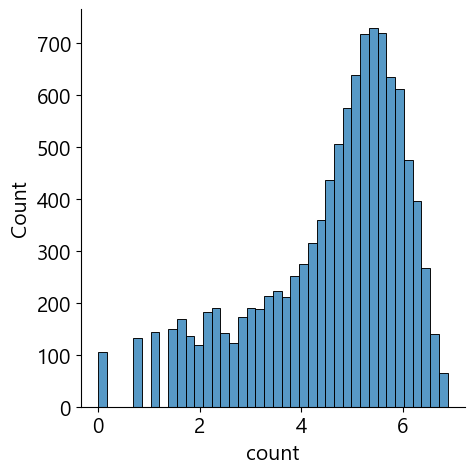

In [32]:
sns.displot(np.log(df_train["count"]))

- 로그변환을 하기 전보다 정규분포에 가까워 진 것을 확인할 수 있음

### datetime별 평균 대여 수량

[Text(0.5, 1.0, '시간별 평균 대여 수량')]

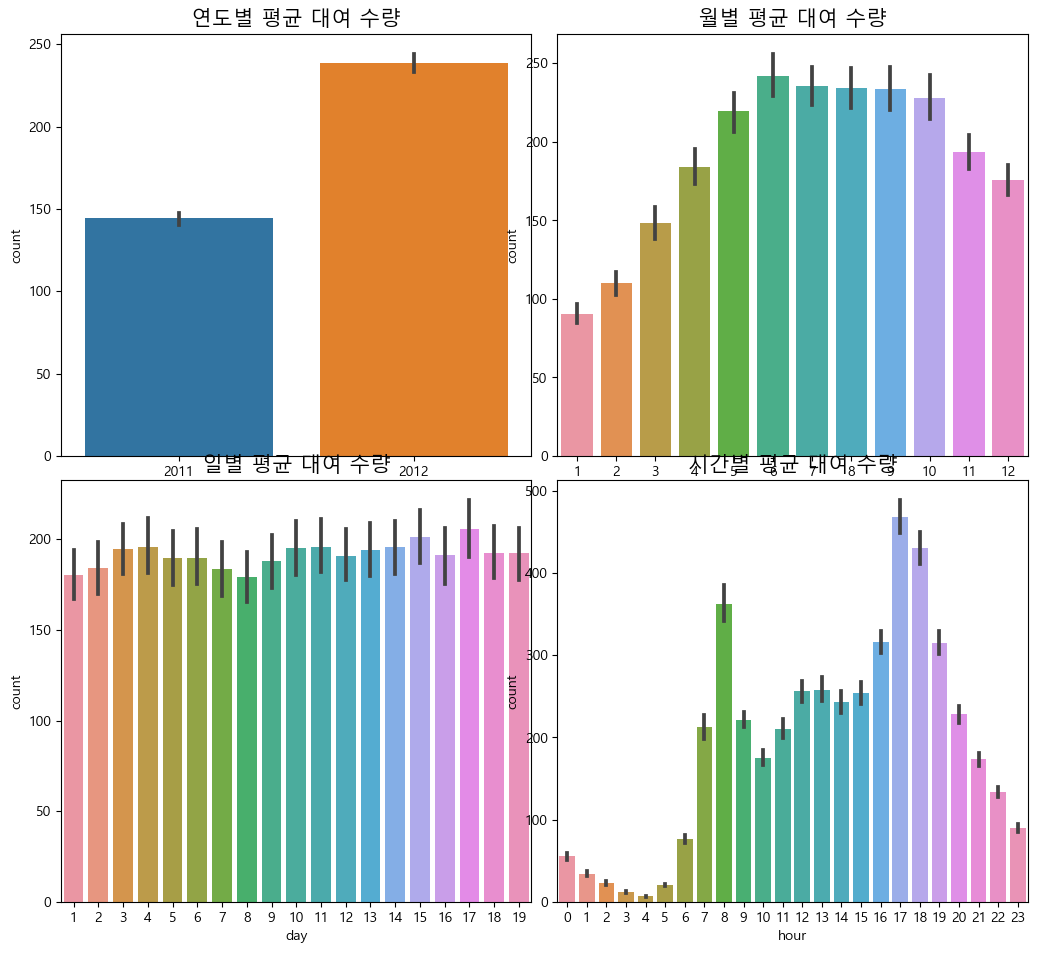

In [33]:
mpl.rc("font", size=10)
mpl.rc("axes", titlesize = 15)
figure, axes = plt.subplots(nrows = 2, ncols = 2)
plt.tight_layout()
figure.set_size_inches(10, 9)

sns.barplot(x="year", y="count", data=df_train, ax=axes[0, 0])
sns.barplot(x="month", y="count", data=df_train, ax=axes[0, 1])
sns.barplot(x="day", y="count", data=df_train, ax=axes[1, 0])
sns.barplot(x="hour", y="count", data=df_train, ax=axes[1, 1])

axes[0, 0].set(title = "연도별 평균 대여 수량")
axes[0, 1].set(title = "월별 평균 대여 수량")
axes[1, 0].set(title = "일별 평균 대여 수량")
axes[1, 1].set(title = "시간별 평균 대여 수량")

1. 2011년보다 2012년 대여가 더 많음
2. 월별은 6월이 가장 많고, 1월이 가장 적음
    - 날이 따뜻할 수록 대여량이 높은 경향이 있음 (6월 ~ 10월 = 여름~가을)
3. 시간은 출퇴근시간인 아침 8시와 저녁 5~6시에 대여가 가장 많음

## "season", "weather", "holiday", "workingday" (범주형 데이터)별 대여 시각화

[Text(0.5, 1.0, 'Workingday')]

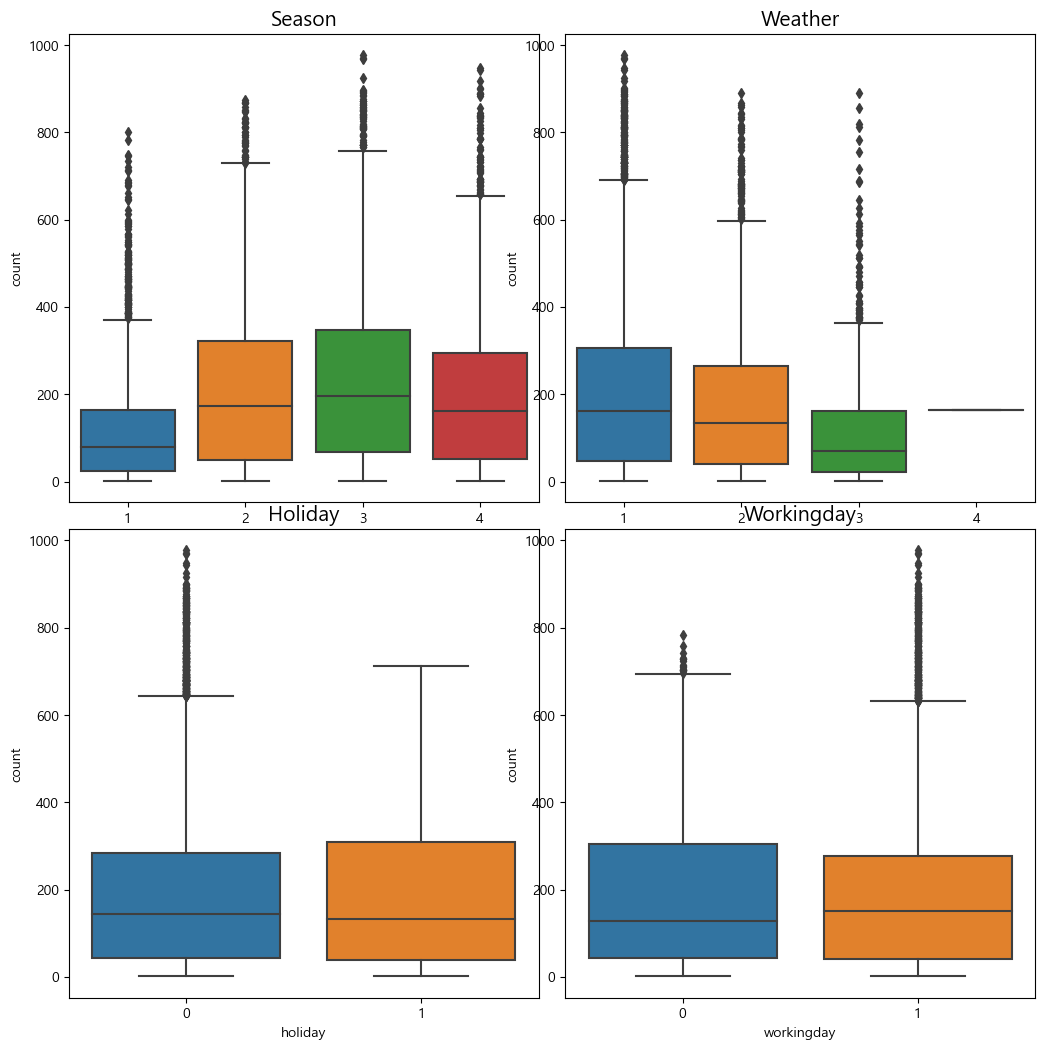

In [34]:
figure, axes = plt.subplots(nrows=2, ncols=2)
plt.tight_layout()
figure.set_size_inches(10, 10)

sns.boxplot(x='season', y='count', data=df_train, ax=axes[0, 0])
sns.boxplot(x='weather', y='count', data=df_train, ax=axes[0, 1])
sns.boxplot(x='holiday', y='count', data=df_train, ax=axes[1, 0])
sns.boxplot(x='workingday', y='count', data=df_train, ax=axes[1, 1])

axes[0, 0].set(title='Season')
axes[0, 1].set(title='Weather')
axes[1, 0].set(title='Holiday')
axes[1, 1].set(title='Workingday')

- season : 계절        
    - 1 : 봄(1분기)
    - 2 : 여름(2분기)
    - 3 : 가을(3분기)
    - 4 : 겨울(4분기)
    - 공식 문서에는 계절로 설명하고 있지만 실제로는 분기로 나누어져 있음
- holiday : 공휴일 여부(0 : 공휴일 아님, 1 : 공휴일)
- workingday : 근무일 여부(0 : 근무일 아님, 1 : 근무일)
    - 주말과 공휴일이 아니면 근무일이라고 간주
- weahther : 날씨
    - 1 : 맑음
    - 2 : 옅은 안개, 약간 흐림
    - 3 : 약간의 눈, 약간의 비와 천둥 번개, 흐림
    - 4 : 폭우와 천둥 번개, 눈과 짙은 안개
    - 숫자가 클수록 날씨가 안 좋음

1. Season은 대여량이 봄에 가장 적고, 가을에 가장 많음
2. Weather는 날씨가 좋을 때 대여량이 많고, 안 좋을수록 적음
    - 4(폭우와 천둥 번개, 눈과 짙은 안개)일 때는 거의 없음
3. Holiday는 공휴일일 때와 아닐 때의 차이는 별로 없으나 공휴일이 아닐 때 이상치가 많음
4. Workingday는 근무일일 때 이상치가 많음

## "workingday", "holiday", "season", "weather"에 따른 시간별 평균 대여 시각화

<Axes: xlabel='hour', ylabel='count'>

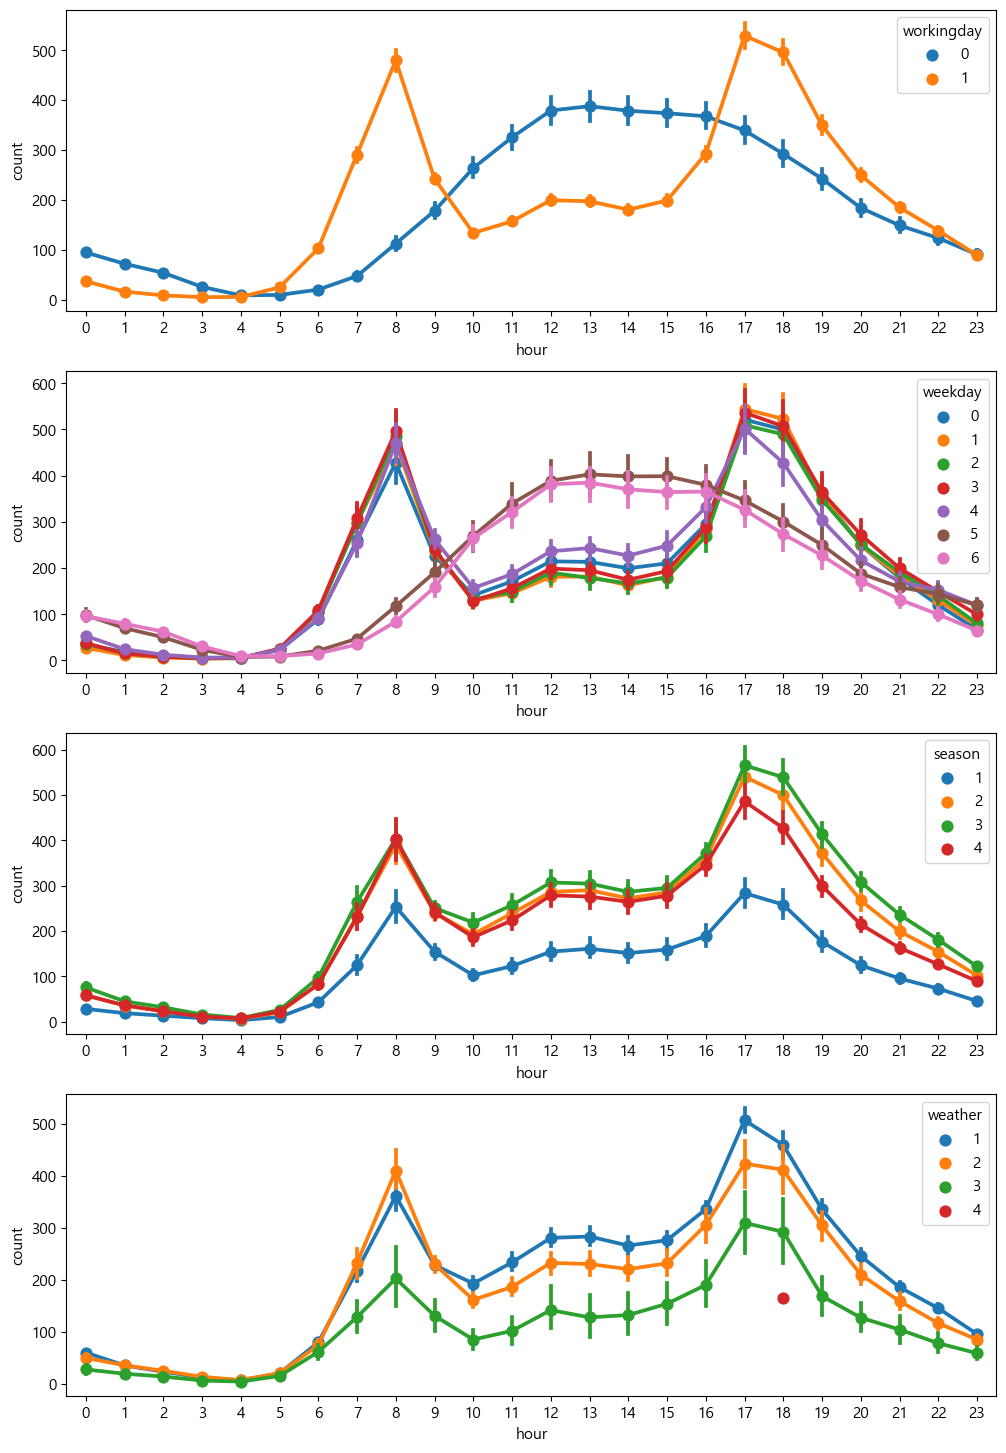

In [35]:
mpl.rc("font", size = 11)
figure, axes = plt.subplots(nrows = 4)
figure.set_size_inches(12, 18)

sns.pointplot(x="hour", y="count", data=df_train, hue="workingday", ax=axes[0])
sns.pointplot(x="hour", y="count", data=df_train, hue="weekday", ax=axes[1])
sns.pointplot(x="hour", y="count", data=df_train, hue="season", ax=axes[2])
sns.pointplot(x="hour", y="count", data=df_train, hue="weather", ax=axes[3])

1. 근무일에는 출퇴근 시간에 대여 수량이 많고, 공휴일에는 오후 12~2시에 가장 많은 것을 확인할 수 있음
2. 요일별 또한 근무일과 유형이 같음
3. season별은 가을 > 여름 > 겨울 > 봄 순을 볼 수 있음
4. 날씨가 좋을수록 대여 수량이 높고,  4(폭우와 천둥 번개, 눈과 짙은 안개)일때는 저녁 6시에 점만 찍혀 있는 것을 확인할 수 있음
    - (..왜지? 생명의 위협으로 탔나..?)

### "temp", "atemp", "windspeed", "humidity" (수치형 데이터) 시각화

<Axes: xlabel='humidity', ylabel='count'>

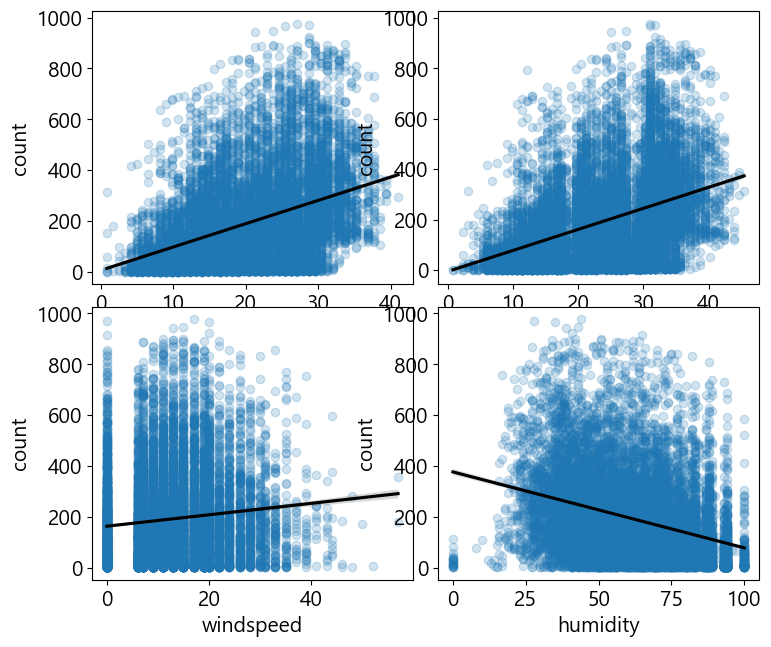

In [36]:
mpl.rc("font", size = 15)
figure, axes = plt.subplots(nrows = 2, ncols = 2)
plt.tight_layout()
figure.set_size_inches(7, 6)

sns.regplot(x="temp", y="count", data=df_train, ax=axes[0, 0], scatter_kws={"alpha":0.2}, line_kws={"color":"black"})
sns.regplot(x="atemp", y="count", data=df_train, ax=axes[0, 1], scatter_kws={"alpha":0.2}, line_kws={"color":"black"})
sns.regplot(x="windspeed", y="count", data=df_train, ax=axes[1, 0], scatter_kws={"alpha":0.2}, line_kws={"color":"black"})
sns.regplot(x="humidity", y="count", data=df_train, ax=axes[1, 1], scatter_kws={"alpha":0.2}, line_kws={"color":"black"})

1. temp가 높을수록 대여량이 많음
2. atemp 또한 temp와 같이 높을수록 대여량이 많음
3. 풍속이 높을수록 대여량이 많다는 것을 볼 수 있음
    - 보통 풍속이 낮을 때 자전거 대여를 더 많이 하지 않을까?
4. 습도가 낮을수록 대여량이 많음
    - = 비 또는 눈이 오지 않을 때 대여량이 많다

### "windspeed" 만 자세히 시각화

<Axes: xlabel='windspeed', ylabel='count'>

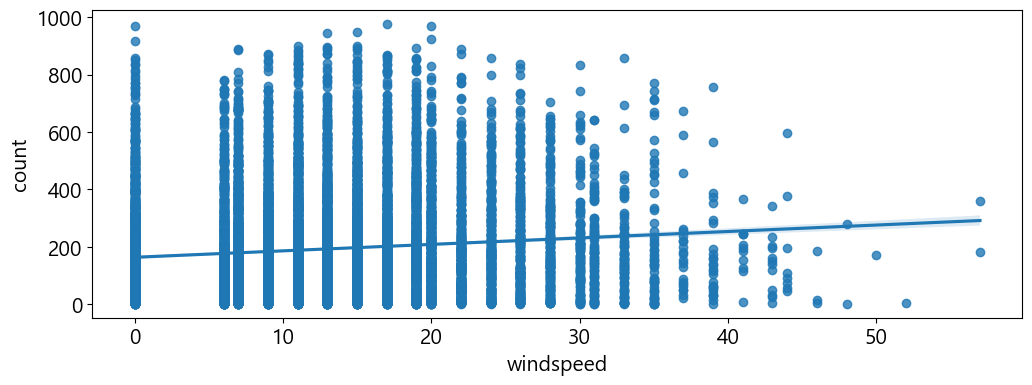

In [37]:
fig = plt.subplots(figsize=(12,4))
sns.regplot(x='windspeed',y='count',data=df_train)

- 확실히 풍속이 0 인 경우가 많고, 풍속이 셀수록 대여 수량이 많다고 나타나있음
    - = 결측치가 있다는 것을 볼 수 있음

## 상관관계 확인

In [38]:
df_corr = df_train.corr()
df_corr

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,weekday,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,-0.004797,0.971524,0.001729,-0.006546,-0.010553,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.012021,0.001731,-0.015877,-0.000354,-0.191832,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.002482,-0.003394,0.009829,0.002780,-0.704267,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.012548,0.012144,-0.007890,-0.022740,-0.047692,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.061226,0.257589,0.015551,0.145430,-0.038466,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.058540,0.264173,0.011866,0.140343,-0.040235,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.078606,0.204537,-0.011335,-0.278011,-0.026507,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,-0.015221,-0.150192,0.036157,0.146631,-0.024804,0.101369
year,-0.004797,0.012021,-0.002482,-0.012548,0.061226,0.058540,-0.078606,-0.015221,1.000000,-0.004932,0.001800,-0.004234,-0.003785,0.260403
month,0.971524,0.001731,-0.003394,0.012144,0.257589,0.264173,0.204537,-0.150192,-0.004932,1.000000,0.001974,-0.006818,-0.002266,0.166862


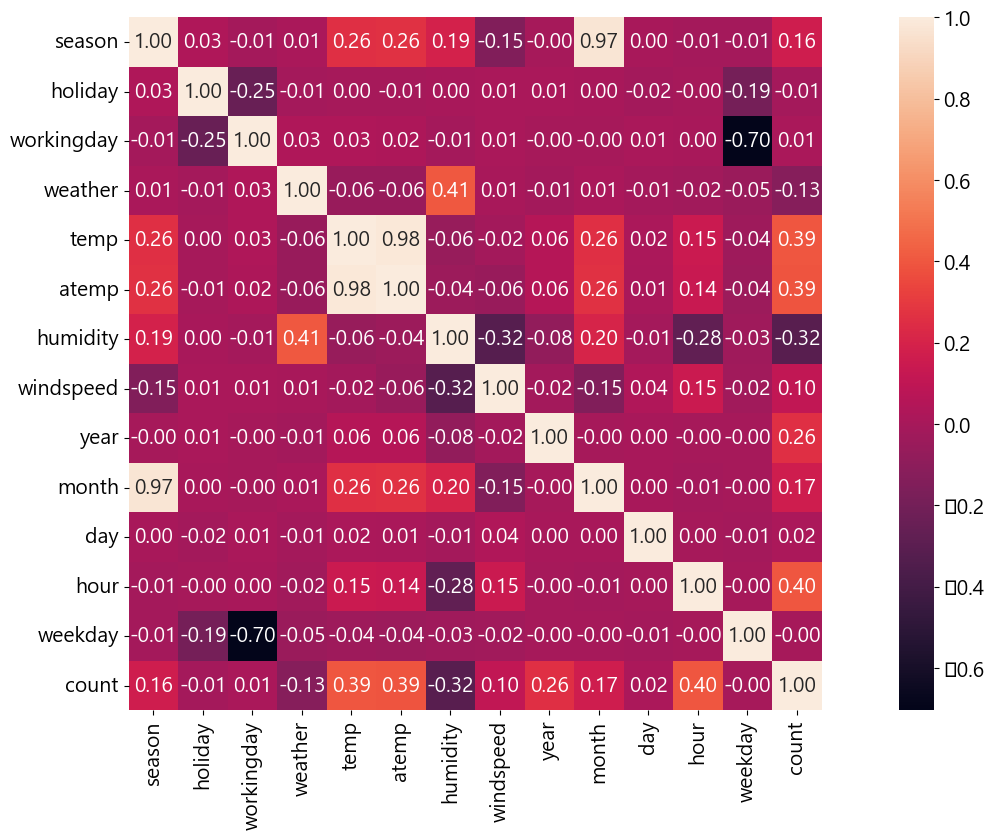

In [39]:
# 상관계수 시각화
plt.figure(figsize = (20, 9))
sns.heatmap(df_corr, annot = True, square = True, fmt=".2f")
plt.show()

- "humidity", "weather"의 상관관계가 낮음

# Baseline Model

### 전처리를 위한 데이터 합치기

In [40]:
all_temp = pd.concat([df_train, df_test], ignore_index = True)

### 데이터 확인

In [41]:
all_temp.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,weekday,count
0,1,0,0,1,9.84,14.395,81,0.0,2011,1,1,0,5,16.0
1,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,1,5,40.0
2,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,2,5,32.0
3,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,3,5,13.0
4,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,4,5,1.0


In [42]:
all_temp.shape

(17379, 14)

In [43]:
all_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   holiday     17379 non-null  int64  
 2   workingday  17379 non-null  int64  
 3   weather     17379 non-null  int64  
 4   temp        17379 non-null  float64
 5   atemp       17379 non-null  float64
 6   humidity    17379 non-null  int64  
 7   windspeed   17379 non-null  float64
 8   year        17379 non-null  int32  
 9   month       17379 non-null  int32  
 10  day         17379 non-null  int32  
 11  hour        17379 non-null  int32  
 12  weekday     17379 non-null  int32  
 13  count       10886 non-null  float64
dtypes: float64(4), int32(5), int64(5)
memory usage: 1.5 MB


In [44]:
all_temp.dtypes

season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
year            int32
month           int32
day             int32
hour            int32
weekday         int32
count         float64
dtype: object

In [45]:
all_temp.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,weekday,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,10886.000000
mean,2.501640,0.028770,0.682721,1.425283,20.376474,23.788755,62.722884,12.736540,2011.502561,6.537775,15.683411,11.546752,3.011451,191.574132
std,1.106918,0.167165,0.465431,0.639357,7.894801,8.592511,19.292983,8.196795,0.500008,3.438776,8.789373,6.914405,2.001966,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,0.000000,0.000000,2011.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,48.000000,7.001500,2011.000000,4.000000,8.000000,6.000000,1.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,63.000000,12.998000,2012.000000,7.000000,16.000000,12.000000,3.000000,145.000000
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,2012.000000,10.000000,23.000000,18.000000,5.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,50.000000,100.000000,56.996900,2012.000000,12.000000,31.000000,23.000000,6.000000,977.000000


### 제출용 test data

In [46]:
test1 = all_temp[pd.isnull(all_temp['count'])]
test1 = test1.drop(["count"], axis = 1)

In [47]:
test1.shape

(6493, 13)

### 모델 train, test split

In [48]:
for_val = all_temp[pd.notna(all_temp['count'])]

In [49]:
for_val.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,weekday,count
0,1,0,0,1,9.84,14.395,81,0.0,2011,1,1,0,5,16.0
1,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,1,5,40.0
2,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,2,5,32.0
3,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,3,5,13.0
4,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,4,5,1.0


In [50]:
for_val.shape

(10886, 14)

In [51]:
x = for_val.drop("count", axis = 1)
y = for_val["count"]

In [52]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

In [53]:
print(x_train.shape, x_test.shape)

(8164, 13) (2722, 13)


In [54]:
x_train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'day', 'hour', 'weekday'],
      dtype='object')

In [55]:
scale_col = x_train.columns.tolist()

In [56]:
scale_col

['season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'month',
 'day',
 'hour',
 'weekday']

### 스케일링

In [57]:
ss = StandardScaler()
scaled_train = ss.fit_transform(x_train[scale_col])
scaled_test = ss.transform(x_test[scale_col])

In [58]:
scaled_train = pd.DataFrame(scaled_train, columns = scale_col)
scaled_test = pd.DataFrame(scaled_test, columns = scale_col)

In [59]:
scaled_train.shape, scaled_test.shape

((8164, 13), (2722, 13))

In [60]:
len(y_train), len(y_test)

(8164, 2722)

In [61]:
scaled_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,weekday
0,0.438373,-0.174034,0.680887,-0.658239,1.084597,1.051561,0.164369,0.025162,-1.004419,0.135620,0.192624,-1.661689,-1.504037
1,-0.456794,-0.174034,0.680887,-0.658239,0.348279,0.335944,-0.510793,1.121515,0.995600,-0.445895,1.473225,1.510943,0.497260
2,-0.456794,-0.174034,0.680887,-0.658239,-1.019170,-0.916388,-0.043373,-0.826470,-1.004419,-0.736652,-1.636808,1.655153,0.497260
3,0.438373,-0.174034,-1.468673,-0.658239,0.453467,0.425691,-0.095309,-0.461834,0.995600,0.717135,1.107339,-0.363794,1.497908
4,-1.351961,-0.174034,0.680887,2.510312,-1.545112,-1.632006,1.618566,0.025162,-1.004419,-1.318167,-1.636808,1.655153,-1.003713


# Case1. 아무것도 하지 않은 case

## LinearRegression

In [62]:
lr = LinearRegression()
lr.fit(scaled_train, y_train)

LinearRegression()

In [63]:
lr.score(scaled_test, y_test)

0.3877529717589109

In [64]:
pred = lr.predict(scaled_test)

In [65]:
rmsle(y_test, pred, False)

1.3014928753491792

### 모델 최적화

In [66]:
# x_train, x_test에 상수항 추가
x = sm.add_constant(scaled_train)

# OLS 검정
full_mod = sm.OLS(y_train.reset_index(drop = True), x)

# 모델 훈련
full_res = full_mod.fit()

# 모델 요약 출력
full_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     400.3
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:09:31   Log-Likelihood:                -52015.
No. Observations:                8164   AIC:                         1.041e+05
Df Residuals:                    8150   BIC:                         1.042e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        191.3398      1.567    122.072      0.000     188.267     194.412
season        -7.4492      6.690     -1.114      0.266     -20.563       5.664
holiday       -0.4200      1.945     -0.216      0.829      -4.233       3.393
workingday     2.1700      2.660      0.816      0.415      -3.044       7.384
weather       -2.8043      1.753     -1.600      0.110      -6.240       0.632
temp           6.9486      9.334      0.744      0.457     -11.349      25.246
atemp         44.4709      9.345      4.759      0.000      26.152      62.789
humidity     -39.0432      1.955    -19.967      0.000     -42.876     -35.210
windspeed      4.7646      1.719      2.772      0.006       1.395       8.134
year          41.0555      1.578     26.021      0.000      37.963      44.148
month         33.9462      6.709      5.060      0.000      20.796      47.097
day            1.4469      1.569      0.922      0.356      -1.629       4.523
hour          55.2114      1.661     33.233      0.000      51.955      58.468
weekday        2.4094      2.627      0.917      0.359      -2.739       7.558
==============================================================================
Omnibus:                     1566.657   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2968.263
Skew:                           1.182   Prob(JB):                         0.00
Kurtosis:                       4.771   Cond. No.                         13.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
# 피처마다 VIF 계수를 출력
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["feature"] = x.columns
vif.round(1)

,VIF_Factor,feature
0,1.0,const
1,18.2,season
2,1.5,holiday
3,2.9,workingday
4,1.3,weather
5,35.5,temp
6,35.5,atemp
7,1.6,humidity
8,1.2,windspeed
9,1.0,year


- AIC : 1.041e+05
- 수정 R 제곱: 0.389
- 개별 변수 P값  : 'holiday'가 가장 무의미

#### 변수제거1

- holiday

In [68]:
new_x = x.drop("holiday", axis = 1)
new_x = sm.add_constant(new_x)
model = sm.OLS(y_train.reset_index(drop = True), new_x)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     433.7
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:09:31   Log-Likelihood:                -52015.
No. Observations:                8164   AIC:                         1.041e+05
Df Residuals:                    8151   BIC:                         1.041e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        191.3398      1.567    122.079      0.000     188.267     194.412
season        -7.5863      6.659     -1.139      0.255     -20.640       5.467
workingday     2.4915      2.204      1.130      0.258      -1.829       6.812
weather       -2.7975      1.752     -1.596      0.110      -6.233       0.638
temp           6.7939      9.306      0.730      0.465     -11.449      25.037
atemp         44.6348      9.314      4.792      0.000      26.378      62.892
humidity     -39.0349      1.955    -19.967      0.000     -42.867     -35.203
windspeed      4.7710      1.719      2.776      0.006       1.402       8.140
year          41.0553      1.578     26.023      0.000      37.963      44.148
month         34.0746      6.682      5.100      0.000      20.977      47.173
day            1.4535      1.569      0.927      0.354      -1.622       4.529
hour          55.2124      1.661     33.235      0.000      51.956      58.469
weekday        2.7165      2.208      1.230      0.219      -1.612       7.045
==============================================================================
Omnibus:                     1567.094   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2969.481
Skew:                           1.182   Prob(JB):                         0.00
Kurtosis:                       4.771   Cond. No.                         13.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
# 피처마다 VIF 계수를 출력
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(new_x.values, i) for i in range(new_x.shape[1])]
vif["feature"] = new_x.columns
vif.round(1)

,VIF_Factor,feature
0,1.0,const
1,18.1,season
2,2.0,workingday
3,1.3,weather
4,35.3,temp
5,35.3,atemp
6,1.6,humidity
7,1.2,windspeed
8,1.0,year
9,18.2,month


- AIC : 1.041e+05
- 수정 R 제곱: 0.389 변함없음
- 개별 변수 P값  : 'temp'가 가장 무의미

#### 변수제거 2

- holiday, temp

In [70]:
new_x = new_x.drop("temp", axis = 1)
new_x = sm.add_constant(new_x)
model = sm.OLS(y_train.reset_index(drop = True), new_x)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     473.1
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:09:32   Log-Likelihood:                -52015.
No. Observations:                8164   AIC:                         1.041e+05
Df Residuals:                    8152   BIC:                         1.041e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        191.3398      1.567    122.083      0.000     188.267     194.412
season        -7.5026      6.658     -1.127      0.260     -20.554       5.549
workingday     2.5654      2.202      1.165      0.244      -1.751       6.882
weather       -2.7572      1.751     -1.574      0.115      -6.190       0.676
atemp         51.3260      1.653     31.051      0.000      48.086      54.566
humidity     -39.1175      1.952    -20.044      0.000     -42.943     -35.292
windspeed      5.0096      1.687      2.969      0.003       1.702       8.317
year          41.0812      1.577     26.047      0.000      37.989      44.173
month         34.0312      6.681      5.094      0.000      20.934      47.128
day            1.4623      1.569      0.932      0.351      -1.613       4.537
hour          55.2097      1.661     33.235      0.000      51.953      58.466
weekday        2.7831      2.206      1.261      0.207      -1.542       7.108
==============================================================================
Omnibus:                     1567.415   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2971.252
Skew:                           1.182   Prob(JB):                         0.00
Kurtosis:                       4.772   Cond. No.                         8.93
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(new_x.values, i) for i in range(new_x.shape[1])]
vif["feature"] = new_x.columns
vif.round(1)

,VIF_Factor,feature
0,1.0,const
1,18.0,season
2,2.0,workingday
3,1.2,weather
4,1.1,atemp
5,1.6,humidity
6,1.2,windspeed
7,1.0,year
8,18.2,month
9,1.0,day


- AIC : 1.041e+05
- 수정 R 제곱: 0.389 변함없음
- 개별 변수 P값  : 'day'가 가장 무의미

#### 변수제거 3

- holiday, temp, day

In [72]:
new_x = new_x.drop("day", axis = 1)
new_x = sm.add_constant(new_x)
model = sm.OLS(y_train.reset_index(drop = True), new_x)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     520.4
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:09:32   Log-Likelihood:                -52016.
No. Observations:                8164   AIC:                         1.041e+05
Df Residuals:                    8153   BIC:                         1.041e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        191.3398      1.567    122.084      0.000     188.268     194.412
season        -7.5155      6.658     -1.129      0.259     -20.567       5.536
workingday     2.5754      2.202      1.170      0.242      -1.741       6.891
weather       -2.7766      1.751     -1.585      0.113      -6.210       0.656
atemp         51.3415      1.653     31.062      0.000      48.101      54.582
humidity     -39.1141      1.952    -20.042      0.000     -42.940     -35.288
windspeed      5.0646      1.686      3.004      0.003       1.759       8.370
year          41.0913      1.577     26.054      0.000      38.000      44.183
month         34.0500      6.681      5.096      0.000      20.953      47.147
hour          55.2106      1.661     33.236      0.000      51.954      58.467
weekday        2.7856      2.206      1.263      0.207      -1.539       7.110
==============================================================================
Omnibus:                     1568.211   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2974.628
Skew:                           1.183   Prob(JB):                         0.00
Kurtosis:                       4.775   Cond. No.                         8.93
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(new_x.values, i) for i in range(new_x.shape[1])]
vif["feature"] = new_x.columns
vif.round(1)

,VIF_Factor,feature
0,1.0,const
1,18.0,season
2,2.0,workingday
3,1.2,weather
4,1.1,atemp
5,1.6,humidity
6,1.2,windspeed
7,1.0,year
8,18.2,month
9,1.1,hour


- AIC : 1.041e+05
- 수정 R 제곱: 0.389 변함없음
- 개별 변수 P값  : 'season'이 가장 무의미

#### 변수제거 4

- holiday, temp, day, season

In [74]:
new_x = new_x.drop("season", axis = 1)
new_x = sm.add_constant(new_x)
model = sm.OLS(y_train.reset_index(drop = True), new_x)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     578.0
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:09:32   Log-Likelihood:                -52016.
No. Observations:                8164   AIC:                         1.041e+05
Df Residuals:                    8154   BIC:                         1.041e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        191.3398      1.567    122.082      0.000     188.267     194.412
workingday     2.7500      2.196      1.252      0.211      -1.555       7.055
weather       -2.7864      1.751     -1.591      0.112      -6.219       0.647
atemp         51.2859      1.652     31.041      0.000      48.047      54.525
humidity     -39.0254      1.950    -20.013      0.000     -42.848     -35.203
windspeed      5.0984      1.686      3.024      0.003       1.793       8.403
year          41.1026      1.577     26.061      0.000      38.011      44.194
month         26.7489      1.675     15.972      0.000      23.466      30.032
hour          55.2311      1.661     33.249      0.000      51.975      58.487
weekday        2.9700      2.200      1.350      0.177      -1.343       7.283
==============================================================================
Omnibus:                     1567.815   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2973.110
Skew:                           1.183   Prob(JB):                         0.00
Kurtosis:                       4.774   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(new_x.values, i) for i in range(new_x.shape[1])]
vif["feature"] = new_x.columns
vif.round(1)

,VIF_Factor,feature
0,1.0,const
1,2.0,workingday
2,1.2,weather
3,1.1,atemp
4,1.5,humidity
5,1.2,windspeed
6,1.0,year
7,1.1,month
8,1.1,hour
9,2.0,weekday


- AIC : 1.041e+05
- 수정 R 제곱: 0.389 변함없음
- 개별 변수 P값  : 'workingday'가 가장 무의미

#### 변수제거 5

- holiday, temp, day, season, workingday

In [76]:
new_x = new_x.drop("workingday", axis = 1)
new_x = sm.add_constant(new_x)
model = sm.OLS(y_train.reset_index(drop = True), new_x)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     650.0
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:09:32   Log-Likelihood:                -52017.
No. Observations:                8164   AIC:                         1.041e+05
Df Residuals:                    8155   BIC:                         1.041e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        191.3398      1.567    122.078      0.000     188.267     194.412
weather       -2.7281      1.751     -1.558      0.119      -6.160       0.704
atemp         51.2540      1.652     31.025      0.000      48.016      54.492
humidity     -39.1555      1.947    -20.107      0.000     -42.973     -35.338
windspeed      5.0481      1.686      2.995      0.003       1.744       8.352
year          41.0713      1.577     26.044      0.000      37.980      44.163
month         26.7832      1.675     15.994      0.000      23.501      30.066
hour          55.2092      1.661     33.237      0.000      51.953      58.465
weekday        1.0422      1.572      0.663      0.507      -2.039       4.123
==============================================================================
Omnibus:                     1578.555   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3012.677
Skew:                           1.187   Prob(JB):                         0.00
Kurtosis:                       4.796   Cond. No.                         2.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(new_x.values, i) for i in range(new_x.shape[1])]
vif["feature"] = new_x.columns
vif.round(1)

,VIF_Factor,feature
0,1.0,const
1,1.2,weather
2,1.1,atemp
3,1.5,humidity
4,1.2,windspeed
5,1.0,year
6,1.1,month
7,1.1,hour
8,1.0,weekday


- AIC : 1.041e+05
- 수정 R 제곱: 0.389 변함없음
- 개별 변수 P값  : 'weekday'가 가장 무의미
    - workingday를 제거하니 weekday의 P값이 0.507로 올라감
        - weekday와 workingday는 상관관계가 있는 것?

#### 변수제거 5

- holiday, temp, day, season, workingday, weekday

In [78]:
new_x = new_x.drop("weekday", axis = 1)
new_x = sm.add_constant(new_x)
model = sm.OLS(y_train.reset_index(drop = True), new_x)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     742.9
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:09:32   Log-Likelihood:                -52017.
No. Observations:                8164   AIC:                         1.041e+05
Df Residuals:                    8156   BIC:                         1.041e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        191.3398      1.567    122.082      0.000     188.267     194.412
weather       -2.7602      1.750     -1.577      0.115      -6.191       0.670
atemp         51.2015      1.650     31.030      0.000      47.967      54.436
humidity     -39.1963      1.946    -20.139      0.000     -43.011     -35.381
windspeed      5.0177      1.685      2.978      0.003       1.715       8.321
year          41.0581      1.577     26.038      0.000      37.967      44.149
month         26.7942      1.674     16.002      0.000      23.512      30.077
hour          55.2007      1.661     33.234      0.000      51.945      58.457
==============================================================================
Omnibus:                     1571.687   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2988.734
Skew:                           1.184   Prob(JB):                         0.00
Kurtosis:                       4.784   Cond. No.                         2.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(new_x.values, i) for i in range(new_x.shape[1])]
vif["feature"] = new_x.columns
vif.round(1)

,VIF_Factor,feature
0,1.0,const
1,1.2,weather
2,1.1,atemp
3,1.5,humidity
4,1.2,windspeed
5,1.0,year
6,1.1,month
7,1.1,hour


- AIC : 1.041e+05
- 수정 R 제곱: 0.389 변함없음
- 개별 변수 P값  : 'weather'가 가장 무의미

In [80]:
new_x = new_x.drop("weather", axis = 1)
new_x = sm.add_constant(new_x)
model = sm.OLS(y_train.reset_index(drop = True), new_x)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     866.1
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:09:32   Log-Likelihood:                -52019.
No. Observations:                8164   AIC:                         1.041e+05
Df Residuals:                    8157   BIC:                         1.041e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        191.3398      1.567    122.071      0.000     188.267     194.412
atemp         51.2640      1.650     31.074      0.000      48.030      54.498
humidity     -40.5491      1.747    -23.208      0.000     -43.974     -37.124
windspeed      4.6320      1.667      2.778      0.005       1.364       7.900
year          40.9792      1.576     25.999      0.000      37.889      44.069
month         26.9594      1.671     16.131      0.000      23.683      30.236
hour          54.9460      1.653     33.235      0.000      51.705      58.187
==============================================================================
Omnibus:                     1576.249   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3004.421
Skew:                           1.186   Prob(JB):                         0.00
Kurtosis:                       4.791   Cond. No.                         1.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(new_x.values, i) for i in range(new_x.shape[1])]
vif["feature"] = new_x.columns
vif.round(1)

,VIF_Factor,feature
0,1.0,const
1,1.1,atemp
2,1.2,humidity
3,1.1,windspeed
4,1.0,year
5,1.1,month
6,1.1,hour


## 모델 훈련

In [82]:
fin_train = scaled_train[["atemp", "humidity", "windspeed", "year", "month", "hour"]]
fin_test = scaled_test[["atemp", "humidity", "windspeed", "year", "month", "hour"]]

In [83]:
fin_lr = LinearRegression()
fin_lr.fit(fin_train, y_train)

LinearRegression()

In [84]:
fin_lr.score(fin_test, y_test)

0.3866345225887684

In [85]:
fin_pred = fin_lr.predict(fin_test)

In [86]:
rmsle(y_test, fin_pred, False)

1.2908615917390727

## RandomForest

## 모델 훈련

In [87]:
rf1 = RandomForestRegressor()

In [88]:
rf1_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}

scorer = make_scorer(rmsle)
gs_rf1 = GridSearchCV(estimator=rf1,
                     param_grid=rf1_params,
                     scoring=scorer,
                     cv=5)

In [89]:
log_y1 = np.log1p(y_train)
gs_rf1.fit(x_train, log_y1)
print("best_params :", gs_rf1.best_params_)

best_params : {'n_estimators': 120, 'random_state': 42}


In [90]:
rf_pred1 = gs_rf1.best_estimator_.predict(x_test)
rf_pred1 = np.expm1(rf_pred1)

In [91]:
rmsle(y_test, rf_pred1, False)

0.29469453462126927

In [92]:
rf_pred_t1 = gs_rf1.best_estimator_.predict(test1)
rf_pred_t1 = np.expm1(rf_pred_t1)

## GradientBoosting

### 모델훈련

In [93]:
gb1 = GradientBoostingRegressor(n_estimators=4000, 
                               alpha=0.01, 
                               max_depth = 5,
                               random_state = 42)

In [94]:
log_y1 = np.log1p(y_train)
gb1.fit(x_train, log_y1)

KeyboardInterrupt: 

In [ ]:
gb_pred1 = gb1.predict(x_test)
gb_pred1 = np.expm1(gb_pred1)

In [ ]:
rmsle(y_test, gb_pred1, False)

In [ ]:
gb_pred_t1 = gb1.predict(test1)
gb_pred_t1 = np.expm1(gb_pred_t1)

## 로지스틱회귀

### 모델 훈련

In [ ]:
logi = LogisticRegression(random_state = 42)

In [ ]:
log_y1 = np.log1p(y_train)
logi.fit(x_train, y_train)
# log_y 안 먹혀요~

In [ ]:
logi_pred = logi.predict(x_test)
logi_pred = np.expm1(logi_pred)

In [ ]:
rmsle(y_test, logi_pred, False) # 이 게 무 슨 일

# Case 2. "humidity", "weather", "season" 제거

In [ ]:
all_temp2 = all_temp

## 데이터 확인

In [ ]:
all_temp2.head()

In [ ]:
all_temp2.shape

In [ ]:
all_temp2.info()

#### 확인했던 상관계수에서의 "humidity"와 "weather"를 제거

In [ ]:
all_temp2 = all_temp2.drop(["humidity", "weather"], axis = 1)
all_temp2.head()

In [ ]:
all_temp2.shape

In [ ]:
all_temp2.dtypes

In [ ]:
all_temp2.describe()

## case2 상관계수

In [ ]:
new_corr = all_temp2.corr()
new_corr

In [ ]:
# 상관계수 시각화
plt.figure(figsize = (20, 9))
sns.heatmap(new_corr, annot = True, square = True, fmt=".2f")
plt.show()

- "season"과 "month"의 상관계수가 유사함.
- "season" 컬럼을 제거해보자

In [ ]:
# season 제거
all_temp2 = all_temp2.drop("season", axis = 1)
all_temp2.head()

## 데이터 나누기

### 제출용 test data

In [ ]:
test2 = all_temp2[pd.isnull(all_temp2['count'])]
test2 = test2.drop(["count"], axis = 1)

In [ ]:
test2.head()

### 모델 train, test split

In [ ]:
for_val2 = all_temp2[pd.notna(all_temp2['count'])]

In [ ]:
for_val2.head()

In [ ]:
for_val2.shape

In [ ]:
x1 = for_val2.drop("count", axis = 1)
y1 = for_val2["count"]

In [ ]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.25, random_state = 42)


In [ ]:
print(x1_train.shape, x1_test.shape)

## RandomForest

## 모델 훈련

In [ ]:
rf2 = RandomForestRegressor()

In [ ]:
rf2_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}

In [ ]:
scorer = make_scorer(rmsle)
gs_rf2 = GridSearchCV(estimator=rf2,
                     param_grid=rf2_params,
                     scoring=scorer,
                     cv=5)

In [ ]:
log_y2 = np.log1p(y1_train)
gs_rf2.fit(x1_train, log_y2)
print("best_params :", gs_rf2.best_params_)

In [ ]:
rf_pred2 = gs_rf2.best_estimator_.predict(x1_test)
rf_pred2 = np.expm1(rf_pred2)

In [ ]:
rmsle(y1_test, rf_pred2, False)

In [ ]:
rf_pred_t2 = gs_rf2.best_estimator_.predict(test2)
rf_pred_t2 = np.expm1(rf_pred_t2)

## GradientBoosting

## 모델 훈련

In [ ]:
gb2 = GradientBoostingRegressor(n_estimators=4000, 
                               alpha=0.01, 
                               max_depth = 5,
                               random_state = 42)

In [ ]:
log_y2 = np.log1p(y1_train)
gb2.fit(x1_train, log_y2)

In [ ]:
gb_pred2 = gb2.predict(x1_test)
gb_pred2 = np.expm1(gb_pred2)

In [ ]:
rmsle(y1_test, gb_pred2, False)

In [ ]:
gb_pred_t2 = gb2.predict(test2)
gb_pred_t2 = np.expm1(gb_pred_t2)

# Case3. "Windspeed" 결측치 변환

In [ ]:
all_temp3 = all_temp
all_temp3.head()

#### "windspeed" 결측치를 평균으로 변환

In [ ]:
all_mean = all_temp3["windspeed"].mean()
all_mean

In [ ]:
all_temp3["windspeed"] = all_temp3["windspeed"].replace(0, all_mean)

In [ ]:
all_temp3.head()

In [ ]:
all_temp3.shape

In [ ]:
all_temp3.info()

In [ ]:
all_temp3.dtypes

In [ ]:
all_temp3.describe()

## 상관관계 확인

In [ ]:
new_corr = all_temp3.corr()
new_corr

In [ ]:
# 상관계수 시각화
plt.figure(figsize = (20, 9))
sns.heatmap(new_corr, annot = True, square = True, fmt=".2f")
plt.show()

In [ ]:
# weather, humidity 제거
all_temp3 = all_temp3.drop(["weather", "humidity"], axis = 1)
all_temp3.head()

In [ ]:
all_temp3.head()

In [ ]:
all_temp3.shape

## 데이터 나누기

### 제출용 test data

In [ ]:
test3 = all_temp3[pd.isnull(all_temp3['count'])]
test3 = test3.drop(["count"], axis = 1)

In [ ]:
test3.head()

### 모델 train, test split

In [ ]:
for_val3 = all_temp3[pd.notna(all_temp3['count'])]

In [ ]:
for_val3.head()

In [ ]:
for_val3.shape

In [ ]:
x2 = for_val3.drop("count", axis = 1)
y2 = for_val3["count"]

In [ ]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = 0.25, random_state = 42)

In [ ]:
print(x2_train.shape, x2_test.shape)

## RandomForest

## 모델 훈련

In [ ]:
rf3 = RandomForestRegressor()

In [ ]:
rf3_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}

In [ ]:
scorer = make_scorer(rmsle)
gs_rf3 = GridSearchCV(estimator=rf3,
                     param_grid=rf3_params,
                     scoring=scorer,
                     cv=5)

In [ ]:
log_y3 = np.log1p(y2_train)
gs_rf3.fit(x2_train, log_y3)
print("best_params :", gs_rf3.best_params_)

In [ ]:
rf_pred3 = gs_rf3.best_estimator_.predict(x2_test)
rf_pred3 = np.expm1(rf_pred3)

In [ ]:
rmsle(y2_test, rf_pred3, False)

In [ ]:
rf_pred_t3 = gs_rf3.best_estimator_.predict(test3)
rf_pred_t3 = np.expm1(rf_pred_t3)

## GradientBoosting

## 모델 훈련

In [ ]:
gb3 = GradientBoostingRegressor(n_estimators=4000, 
                               alpha=0.01, 
                               max_depth = 5,
                               random_state = 42)

In [ ]:
log_y3 = np.log1p(y2_train)
gb3.fit(x2_train, log_y3)

In [ ]:
gb_pred3 = gb3.predict(x2_test)
gb_pred3 = np.expm1(gb_pred3)

In [ ]:
rmsle(y2_test, gb_pred3, False)

In [ ]:
gb_pred_t3 = gb3.predict(test3)
gb_pred_t3 = np.expm1(gb_pred_t3)

# Case4. "season"컬럼 get_dummies 변환

In [ ]:
all_temp4 = all_temp
all_temp4.head()

In [ ]:
# 'season' 컬럼 변환
all_temp4 = pd.get_dummies(all_temp4, columns=['season'])

In [ ]:
all_temp4.head()

In [ ]:
all_temp4.shape

In [ ]:
all_temp4.info()

## 상관계수 확인

In [ ]:
new_corr = all_temp4.corr()
new_corr

In [ ]:
# 상관계수 시각화
plt.figure(figsize = (20, 9))
sns.heatmap(new_corr, annot = True, square = True, fmt=".2f")
plt.show()

## 데이터 나누기

### 제출용 test data

In [ ]:
test4 = all_temp4[pd.isnull(all_temp4['count'])]
test4 = test4.drop(["count"], axis = 1)

In [ ]:
test4.head()

### 모델 train, test split

In [ ]:
for_val4 = all_temp4[pd.notna(all_temp4['count'])]

In [ ]:
for_val4.head()

In [ ]:
for_val4.shape

In [ ]:
x3 = for_val4.drop("count", axis = 1)
y3 = for_val4["count"]

In [ ]:
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size = 0.25, random_state = 42)

In [ ]:
print(x3_train.shape, x3_test.shape)

## RandomForest

## 모델 훈련

In [ ]:
rf4 = RandomForestRegressor()

In [ ]:
rf4_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}

scorer = make_scorer(rmsle)
gs_rf4 = GridSearchCV(estimator=rf4,
                     param_grid=rf4_params,
                     scoring=scorer,
                     cv=5)

In [ ]:
log_y4 = np.log1p(y3_train)
gs_rf4.fit(x3_train, log_y4)
print("best_params :", gs_rf4.best_params_)

In [ ]:
rf_pred4 = gs_rf4.best_estimator_.predict(x3_test)
rf_pred4 = np.expm1(rf_pred4)

In [ ]:
rmsle(y3_test, rf_pred4, False)

In [ ]:
rf_pred_t4 = gs_rf4.best_estimator_.predict(test4)
rf_pred_t4 = np.expm1(rf_pred_t4)

## GradientBoosting

## 모델 훈련

In [ ]:
gb4 = GradientBoostingRegressor(n_estimators=4000, 
                               alpha=0.01, 
                               max_depth = 5,
                               random_state = 42)

In [ ]:
log_y4 = np.log1p(y3_train)
gb4.fit(x3_train, log_y4)

In [ ]:
gb_pred4 = gb4.predict(x3_test)
gb_pred4 = np.expm1(gb_pred4)

In [ ]:
rmsle(y3_test, gb_pred4, False)

In [ ]:
gb_pred_t4 = gb4.predict(test4)
gb_pred_t4 = np.expm1(gb_pred_t4)

# Case5. "season"변환, "windspeed" 컬럼제거

In [ ]:
all_temp5 = all_temp
all_temp5

In [ ]:
# 'season' 컬럼 변환
all_temp5 = pd.get_dummies(all_temp5, columns=['season'])

In [ ]:
# 이상치가 있는 "windspeed" 컬럼 제거
all_temp5 = all_temp5.drop("windspeed", axis = 1)

In [ ]:
all_temp5.head()

In [ ]:
all_temp.shape

## 데이터 나누기

### 제출용 test data

In [ ]:
test5 = all_temp5[pd.isnull(all_temp5['count'])]
test5 = test5.drop(["count"], axis = 1)

### 모델 train, test split

In [ ]:
for_val5 = all_temp5[pd.notna(all_temp5['count'])]

In [ ]:
for_val5.head()

In [ ]:
for_val5.shape

In [ ]:
x4 = for_val5.drop("count", axis = 1)
y4 = for_val5["count"]

In [ ]:
x4_train, x4_test, y4_train, y4_test = train_test_split(x4, y4, test_size = 0.25, random_state = 42)

In [ ]:
print(x4_train.shape, x4_test.shape)

## RandomForest

## 모델 훈련

In [ ]:
rf5 = RandomForestRegressor()

In [ ]:
rf5_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}

scorer = make_scorer(rmsle)
gs_rf5 = GridSearchCV(estimator=rf5,
                     param_grid=rf5_params,
                     scoring=scorer,
                     cv=5)

In [ ]:
log_y5 = np.log1p(y4_train)
gs_rf5.fit(x4_train, log_y5)
print("best_params :", gs_rf5.best_params_)

In [ ]:
rf_pred5 = gs_rf5.best_estimator_.predict(x4_test)
rf_pred5 = np.expm1(rf_pred5)

In [ ]:
rmsle(y4_test, rf_pred5, False)

In [ ]:
rf_pred_t5 = gs_rf5.best_estimator_.predict(test5)
rf_pred_t5 = np.expm1(rf_pred_t5)

## GradientBoosting

## 모델 훈련

In [ ]:
gb5 = GradientBoostingRegressor(n_estimators=4000, 
                               alpha=0.01, 
                               max_depth = 5,
                               random_state = 42)

In [ ]:
log_y5 = np.log1p(y4_train)
gb5.fit(x4_train, log_y5)

In [ ]:
gb_pred5 = gb5.predict(x4_test)
gb_pred5 = np.expm1(gb_pred5)

In [ ]:
rmsle(y4_test, gb_pred5, False)

In [ ]:
gb_pred_t5 = gb5.predict(test5)
gb_pred_t5 = np.expm1(gb_pred_t5)

# Case6. "weather"이상치 제거, "windspeed" 제거

In [ ]:
df_train2 = df_train

In [ ]:
# weather에서 확인했던 이상치인 4를 제외한 데이터만 추출
df_train2 = df_train2[df_train2["weather"] != 4]

In [ ]:
all_temp6 = pd.concat([df_train2, df_test], ignore_index = True)
all_temp6.head()

In [ ]:
# 이상치가 있는 "windspeed" 컬럼 제거
all_temp6 = all_temp6.drop("windspeed", axis = 1)

In [ ]:
all_temp6.head()

In [ ]:
all_temp6.shape

## 데이터 나누기

### 제출용 test data

In [ ]:
test6 = all_temp6[pd.isnull(all_temp6['count'])]
test6 = test6.drop(["count"], axis = 1)

In [ ]:
test6

### 모델 train, test split

In [ ]:
for_val6 = all_temp6[pd.notna(all_temp6['count'])]

In [ ]:
for_val6.head()

In [ ]:
for_val6.shape

In [ ]:
x5 = for_val6.drop("count", axis = 1)
y5 = for_val6["count"]

In [ ]:
x5_train, x5_test, y5_train, y5_test = train_test_split(x5, y5, test_size = 0.25, random_state = 42)

In [ ]:
print(x5_train.shape, x5_test.shape)

## RandomForest

## 모델 훈련

In [ ]:
rf6 = RandomForestRegressor()

In [ ]:
rf6_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}

scorer = make_scorer(rmsle)
gs_rf6 = GridSearchCV(estimator=rf6,
                     param_grid=rf6_params,
                     scoring=scorer,
                     cv=5)

In [ ]:
log_y6 = np.log1p(y5_train)
gs_rf6.fit(x5_train, log_y6)
print("best_params :", gs_rf6.best_params_)

In [ ]:
rf_pred6 = gs_rf6.best_estimator_.predict(x5_test)
rf_pred6 = np.expm1(rf_pred6)

In [ ]:
rmsle(y5_test, rf_pred6, False)

In [ ]:
rf_pred_t6 = gs_rf6.best_estimator_.predict(test6)
rf_pred_t6 = np.expm1(rf_pred_t6)

## GradientBoosting

## 모델 훈련

In [ ]:
gb6 = GradientBoostingRegressor(n_estimators=4000, 
                               alpha=0.01, 
                               max_depth = 5,
                               random_state = 42)


In [ ]:
log_y6 = np.log1p(y5_train)
gb6.fit(x5_train, log_y6)

In [ ]:
gb_pred6 = gb6.predict(x5_test)
gb_pred6 = np.expm1(gb_pred6)

In [ ]:
rmsle(y5_test, gb_pred6, False)

In [ ]:
gb_pred_t6 = gb6.predict(test6)
gb_pred_t6 = np.expm1(gb_pred_t6)

# Case7. "weather" 이상치 제거, "season" 변환, "windspeed", "month" 컬럼 제거

In [ ]:
df_train3 = df_train

In [ ]:
# weather에서 확인했던 이상치인 4를 제외한 데이터만 추출
df_train3 = df_train3[df_train3["weather"] != 4]
df_train3.head()

In [ ]:
all_temp7 = pd.concat([df_train3, df_test], ignore_index = True)
all_temp7.head()

In [ ]:
# 'season' 컬럼 변환
all_temp7 = pd.get_dummies(all_temp7, columns=['season'])

In [ ]:
# 이상치가 있는 "windspeed"과 "season" 중복 있는 "month" 컬럼 제거
all_temp7 = all_temp7.drop(["windspeed", "month"], axis = 1)
all_temp7.head()

In [ ]:
all_temp7.shape

## 데이터 나누기

### 제출용 test data

In [ ]:
test7 = all_temp7[pd.isnull(all_temp7['count'])]
test7 = test7.drop(["count"], axis = 1)

In [ ]:
test7

### 모델 train, test split

In [ ]:
for_val7 = all_temp7[pd.notna(all_temp7['count'])]

In [ ]:
for_val7.head()

In [ ]:
for_val7.shape

In [ ]:
x6 = for_val7.drop("count", axis = 1)
y6 = for_val7["count"]

In [ ]:
x6_train, x6_test, y6_train, y6_test = train_test_split(x6, y6, test_size = 0.25, random_state = 42)

In [ ]:
print(x6_train.shape, x6_test.shape)

## RandomForest

## 모델 훈련

In [ ]:
rf7 = RandomForestRegressor()

In [ ]:
rf7_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}

scorer = make_scorer(rmsle)
gs_rf7 = GridSearchCV(estimator=rf7,
                     param_grid=rf7_params,
                     scoring=scorer,
                     cv=5)

In [ ]:
log_y7 = np.log1p(y6_train)
gs_rf7.fit(x6_train, log_y7)
print("best_params :", gs_rf7.best_params_)

In [ ]:
rf_pred7 = gs_rf7.best_estimator_.predict(x6_test)
rf_pred7 = np.expm1(rf_pred7)

In [ ]:
rmsle(y6_test, rf_pred7, False)

In [ ]:
rf_pred_t7 = gs_rf7.best_estimator_.predict(test7)
rf_pred_t7 = np.expm1(rf_pred_t7)

## GradientBoosting

## 모델 훈련

In [ ]:
gb7 = GradientBoostingRegressor(n_estimators=4000, 
                               alpha=0.01, 
                               max_depth = 5,
                               random_state = 42)

In [ ]:
log_y7 = np.log1p(y6_train)
gb7.fit(x6_train, log_y7)

In [ ]:
gb_pred7 = gb7.predict(x6_test)
gb_pred7 = np.expm1(gb_pred7)

In [ ]:
rmsle(y6_test, gb_pred7, False)

In [ ]:
gb_pred_t7 = gb7.predict(test7)
gb_pred_t7 = np.expm1(gb_pred_t7)

## 파일 추출

In [ ]:
case1_pred_rf = pd.DataFrame({"datetime" : test["datetime"], "count" : rf_pred_t1.flatten()})
case1_pred_rf.to_csv("./data/bike/case1_pred_rf.csv".format(), index=False)

In [ ]:
case1_pred_gb = pd.DataFrame({"datetime" : test["datetime"], "count" : gb_pred_t1.flatten()})
case1_pred_gb.to_csv("./data/bike/case1_pred_gb.csv".format(), index=False)

In [ ]:
case2_pred_rf = pd.DataFrame({"datetime" : test["datetime"], "count" : rf_pred_t2.flatten()})
case2_pred_rf.to_csv("./data/bike/case2_pred_rf.csv".format(), index=False)

In [ ]:
case2_pred_gb = pd.DataFrame({"datetime" : test["datetime"], "count" : gb_pred_t2.flatten()})
case2_pred_gb.to_csv("./data/bike/case2_pred_gb.csv".format(), index=False)

In [ ]:
case3_pred_rf = pd.DataFrame({"datetime" : test["datetime"], "count" : rf_pred_t3.flatten()})
case3_pred_rf.to_csv("./data/bike/case3_pred_rf.csv".format(), index=False)

In [ ]:
case3_pred_gb = pd.DataFrame({"datetime" : test["datetime"], "count" : gb_pred_t3.flatten()})
case3_pred_gb.to_csv("./data/bike/case3_pred_gb.csv".format(), index=False)

In [ ]:
case4_pred_rf = pd.DataFrame({"datetime" : test["datetime"], "count" : rf_pred_t4.flatten()})
case4_pred_rf.to_csv("./data/bike/case4_pred_rf.csv".format(), index=False)

In [ ]:
case4_pred_gb = pd.DataFrame({"datetime" : test["datetime"], "count" : gb_pred_t4.flatten()})
case4_pred_gb.to_csv("./data/bike/case4_pred_gb.csv".format(), index=False)

In [ ]:
case5_pred_rf = pd.DataFrame({"datetime" : test["datetime"], "count" : rf_pred_t5.flatten()})
case5_pred_rf.to_csv("./data/bike/case5_pred_rf.csv".format(), index=False)

In [ ]:
case5_pred_gb = pd.DataFrame({"datetime" : test["datetime"], "count" : gb_pred_t5.flatten()})
case5_pred_gb.to_csv("./data/bike/case5_pred_gb.csv".format(), index=False)

In [ ]:
case6_pred_rf = pd.DataFrame({"datetime" : test["datetime"], "count" : rf_pred_t6.flatten()})
case6_pred_rf.to_csv("./data/bike/case6_pred_rf.csv".format(), index=False)

In [ ]:
case6_pred_gb = pd.DataFrame({"datetime" : test["datetime"], "count" : gb_pred_t6.flatten()})
case6_pred_gb.to_csv("./data/bike/case6_pred_gb.csv".format(), index=False)

In [ ]:
case7_pred_rf = pd.DataFrame({"datetime" : test["datetime"], "count" : rf_pred_t7.flatten()})
case7_pred_rf.to_csv("./data/bike/case7_pred_rf.csv".format(), index=False)

In [ ]:
case7_pred_gb = pd.DataFrame({"datetime" : test["datetime"], "count" : gb_pred_t7.flatten()})
case7_pred_gb.to_csv("./data/bike/case7_pred_gb.csv".format(), index=False)

# 선생님 풀이

In [95]:
def rmsle(y_true, y_pred, convertExp = True):
    '''
    실제 타깃값과 예측값을 인수로 전달하면 RMSLE 수치를 반환하는 함수
    convertExp : 입력 데이터를 지수변환할지 정하는 파라미터
    타깃값으로 log(count)를 사용한 경우에는 지수변환을 해줘야 함
    '''
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)

    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true + 1))
    log_pred = np.nan_to_num(np.log(y_pred + 1))

    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))

    return output

- RMSLE는 예측값과 실제값 사이의 상대적인 오차를 측정
- 즉, 예측값과 실제값 사이의 비율을 중요시
    - 이는 큰 값에 대한 예측이 작은 값에 대한 예측보다 더 많은 오차릴 가지더라도, 그 차이가 상대적으로 작다면 RMSLE 값이 크게 증가하지 않음
    - 따라서 예측값과 실제값의 비율이 중요한 상황에서 RMSLE를 사용
- RMSLE는 오차가 크게 발생했을 때 그에 대해 더 관대한 경향이 있음
- 예측값이 실제값보다 매우 크거나 작은 경우에도 오차와 절대적인 크기가 아닌 상대적인 크기를 고려하기 때문에, 모델의 성능을 과대평가할 위험이 있음

In [97]:
SEED = 12

# 데이터 확인

In [98]:
train_df = pd.read_csv("./data/bike/train.csv")
test_df = pd.read_csv("./data/bike/test.csv")
submission_df = pd.read_csv("./data/bike/sampleSubmission.csv")

In [99]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [100]:
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [101]:
submission_df.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [102]:
train_df.shape, test_df.shape, submission_df.shape

((10886, 12), (6493, 9), (6493, 2))

In [103]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


- 결측값 없음
- datetime은 날짜인데 object로 표현되어 전처리가 필요함
    - 날짜, 연도, 월, 일 , 시, 분 초 로 각각 컬럼 생성

In [104]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [105]:
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


# 데이터 분석

## datetime 구성요소별로 나누기

In [106]:
train_df["datetime"][0]

'2011-01-01 00:00:00'

In [107]:
train_df["datetime"][0].split()

['2011-01-01', '00:00:00']

In [108]:
train_df["datetime"][0].split()[0].split("-")

['2011', '01', '01']

In [109]:
train_df["datetime"][0].split()[1].split(":")

['00', '00', '00']

In [110]:
train_df["datetime"].map(lambda x: x.split()[0])

0        2011-01-01
1        2011-01-01
2        2011-01-01
3        2011-01-01
4        2011-01-01
            ...    
10881    2012-12-19
10882    2012-12-19
10883    2012-12-19
10884    2012-12-19
10885    2012-12-19
Name: datetime, Length: 10886, dtype: object

In [111]:
train_df["date"] = train_df["datetime"].map(lambda x: x.split()[0])
train_df["year"] = train_df["datetime"].map(lambda x: x.split()[0].split("-")[0])
train_df["month"] = train_df["datetime"].map(lambda x: x.split()[0].split("-")[1])
train_df["day"] = train_df["datetime"].map(lambda x: x.split()[0].split("-")[2])
train_df["hour"] = train_df["datetime"].map(lambda x: x.split()[1].split(":")[0])
train_df["minute"] = train_df["datetime"].map(lambda x: x.split()[1].split(":")[1])
train_df["second"] = train_df["datetime"].map(lambda x: x.split()[1].split(":")[2])

In [112]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00


In [113]:
calendar.day_name[pd.to_datetime(train_df["date"])[0].weekday()]

'Saturday'

In [114]:
train_df["weekday"] = train_df["date"].map(lambda x: calendar.day_name[pd.to_datetime(x).weekday()])

## season, weather 범주형 데이터 문자열로 변환

In [115]:
train_df["season"] = train_df["season"].map({1 : "Spring",
                                            2 : "Summer",
                                            3 : "Fall",
                                            4 : "Winter"})
train_df["weather"] = train_df["weather"].map({1 : "Clear",
                                              2 : "Mist, Few clounds",
                                              3 : "Light Snow, Rain, Thunder",
                                              4 : "Heavy Snow, Rain, Thunder"})

In [116]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


## 정리

- date 컬럼의 정보는 year, month, day에도 있어서 제거하는 편이 더 나을 수도 있음
- month 컬럼은 세 달씩 묶으면 season이 되기 때문에 연관성이 너무 높아서 제거하는 편이 더 나을 수 있음

## 데이터 시각화

### 종속변수 분포도

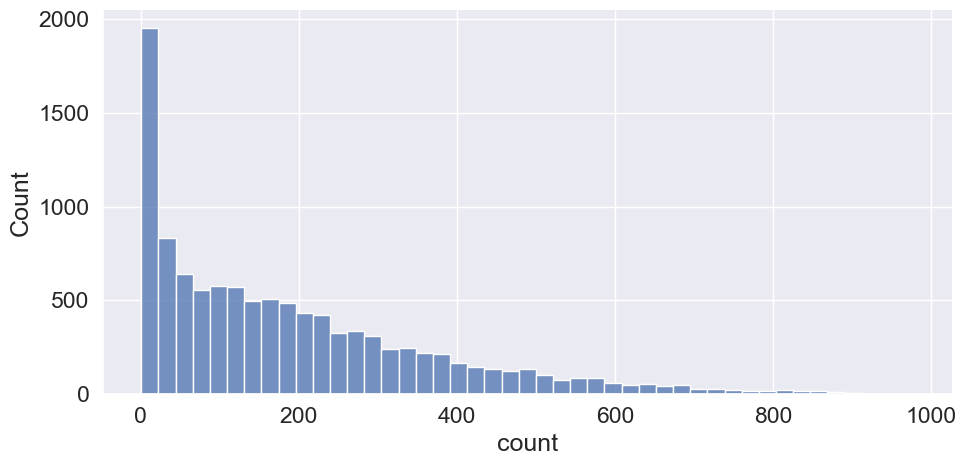

In [117]:
sns.set(font_scale = 1.5)
sns.displot(train_df["count"], height = 5, aspect = 2)
plt.show()

- 회귀 모델이 좋은 성능을 내기 위해서는 데이터가 정규분포를 따르는 것이 제일 좋은데 0 근처에 몰려 있음

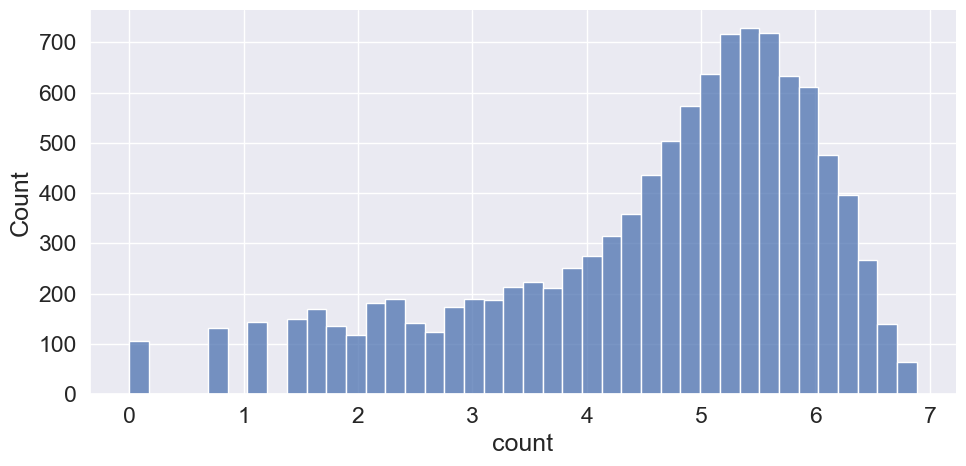

In [118]:
sns.displot(np.log(train_df["count"]), height = 5, aspect = 2)
plt.show()

- log 변환하면 큰 값은 더 많이 줄이고 작은 값은 조금만 줄여서 전체 범위가 줄어듦
- count로 예측하는 것 보다 log(count)로 예측하는 것이 더 정확할 수 있음
    - log(count)로 예측하면 예측값에 지수변환하여 실제값이 count로 복원해야함

### 시간관련 컬럼과 종속변수 관계

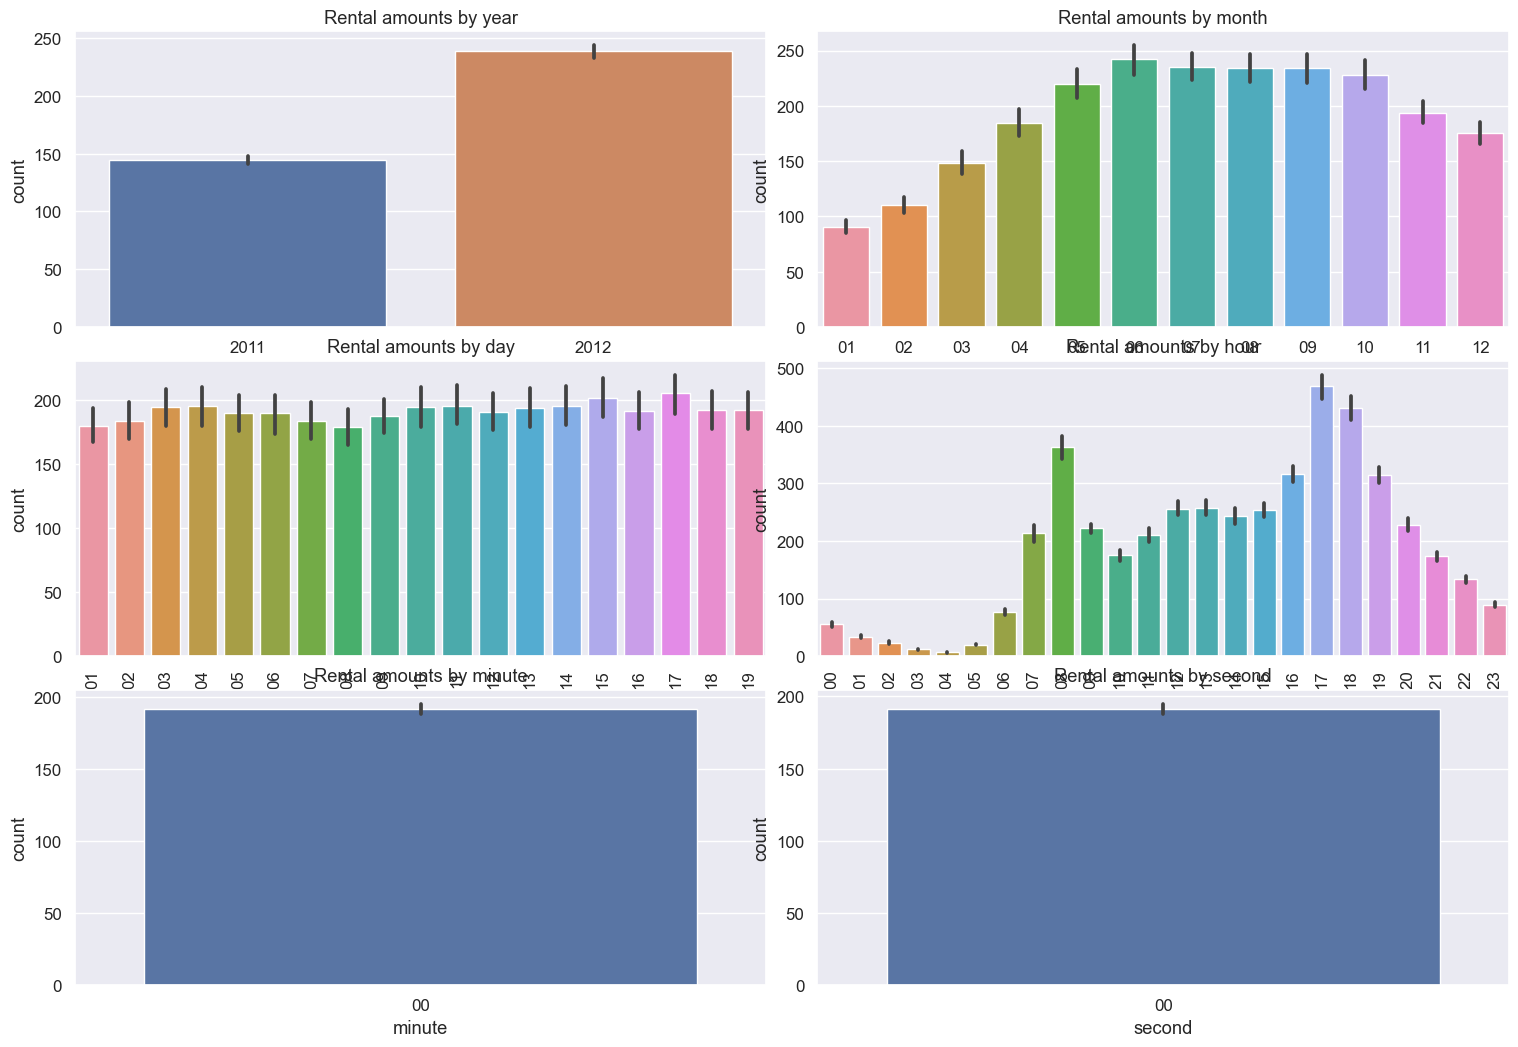

In [119]:
# 스텝1 : m 행 n 열 Figure 준비
sns.set(font_scale = 1.1)
fig, axes = plt.subplots(nrows = 3, ncols = 2) # 3행 2열 Figure 생성
plt.tight_layout() # 그래프 사이 여백 확보
fig.set_size_inches(15, 10)

# 스텝 2: 각 축에 서브플롯 할당
# 각 축에 연도, 월, 일, 시간, 분, 초 별 평균 대여 수량 막대 그래프 할당
sns.barplot(x = "year", y = "count", data = train_df, ax = axes[0, 0])
sns.barplot(x = "month", y = "count", data = train_df, ax = axes[0, 1])
sns.barplot(x = "day", y = "count", data = train_df, ax = axes[1, 0])
sns.barplot(x = "hour", y = "count", data = train_df, ax = axes[1, 1])
sns.barplot(x = "minute", y = "count", data = train_df, ax = axes[2, 0])
sns.barplot(x = "second", y = "count", data = train_df, ax = axes[2, 1])

# 스텝 3 : 세부 설정
# 3-1 : 서브플롯에 제목 달기
axes[0, 0].set(title = "Rental amounts by year")
axes[0, 1].set(title = "Rental amounts by month")
axes[1, 0].set(title = "Rental amounts by day")
axes[1, 1].set(title = "Rental amounts by hour")
axes[2, 0].set(title = "Rental amounts by minute")
axes[2, 1].set(title = "Rental amounts by second")

# 3-2 : 1행에 위치한 서브플롯의 x축 레이블 90도 회전
axes[1, 0].tick_params(axis = "x", labelrotation = 90)
axes[1, 1].tick_params(axis = "x", labelrotation = 90)

plt.show()

- 2011년보다 2012년 대여량이 더 많음
- 6월에 가장 대여량이 많고 1월에 가장 적음
    - 날씨가 따뜻할수록 대여 수량이 많을 수 있음
- day는 일별 대여량에 큰 차이가 없고 훈련데이터와 테스트 데이터의 day 값이 다르기 때문에 제거해야함
- 새벽 4시에 가장 대여량이 적고 아침 8시와 저녁 5~6시 대여량이 가장 많음
- minute과 second는 0 데이터만 존재
    - 아무 정보 없기 때문에 저게해야함

### 범주형 데이터 시각화

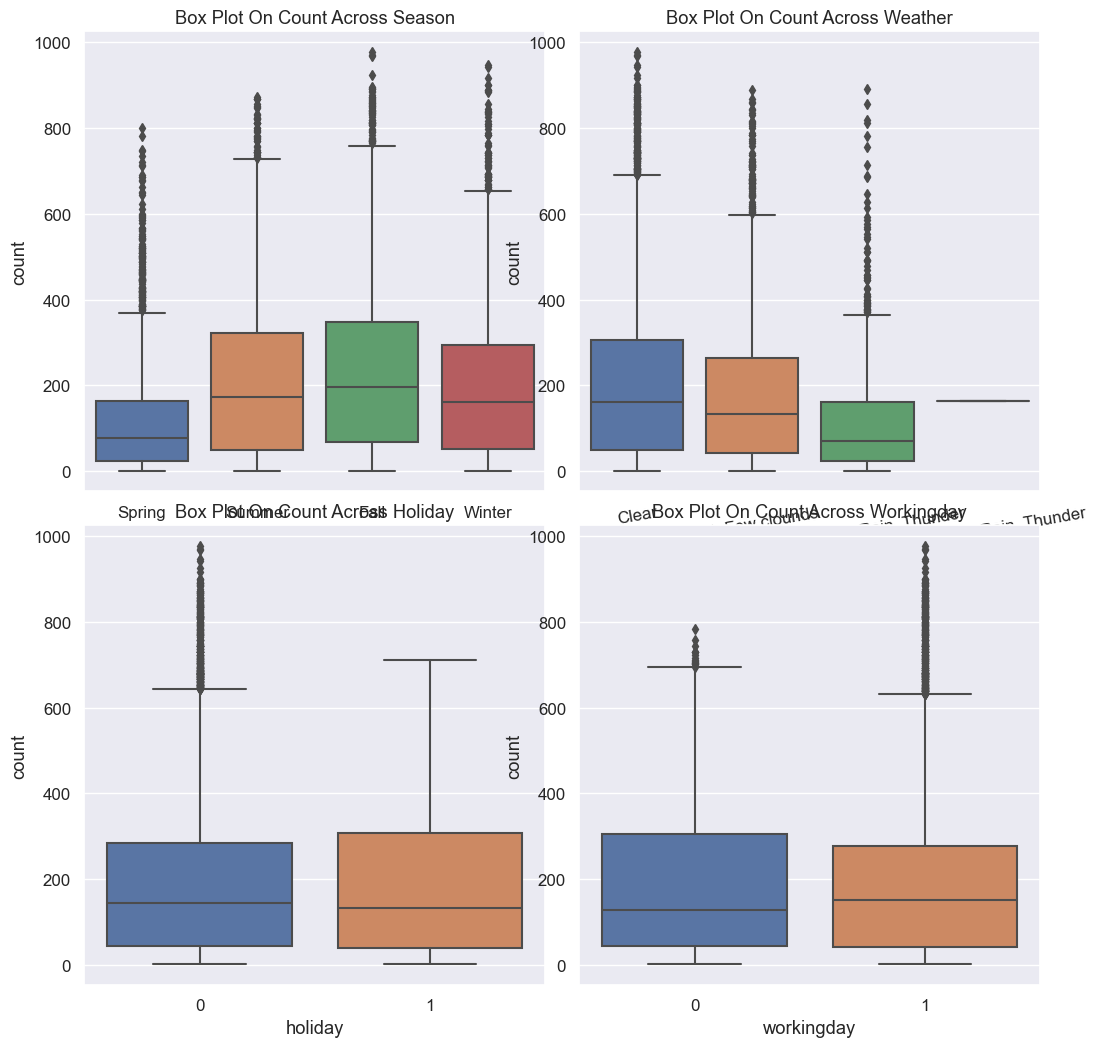

In [120]:
# 스텝1 : m 행 n 열 Figure 준비
sns.set(font_scale = 1.1)
fig, axes = plt.subplots(nrows = 2, ncols = 2) # 2행 2열 Figure 생성
plt.tight_layout() # 그래프 사이 여백 확보
fig.set_size_inches(10, 10)

# 스텝 2 : 서브플롯 할당
# 계절, 날씨, 공휴일, 근무일 별 대여 수량 박스플롯
sns.boxplot(x = "season", y = "count", data = train_df, ax = axes[0, 0])
sns.boxplot(x = "weather", y = "count", data = train_df, ax = axes[0, 1])
sns.boxplot(x = "holiday", y = "count", data = train_df, ax = axes[1, 0])
sns.boxplot(x = "workingday", y = "count", data = train_df, ax = axes[1, 1])

# 스텝 3 : 세부 설정
# 3-1 : 서브플롯에 제목 달기
axes[0, 0].set(title = "Box Plot On Count Across Season")
axes[0, 1].set(title = "Box Plot On Count Across Weather")
axes[1, 0].set(title = "Box Plot On Count Across Holiday")
axes[1, 1].set(title = "Box Plot On Count Across Workingday")

# 3-2 : x축 레이블 겹침 해결
axes[0, 1].tick_params("x", labelrotation = 10) # 10도 회전

plt.show()

- 봄에 대여량이 가장 적고 가을에 가장 많음
- 날시가 좋을 때 가장 대여량이 많고 날씨가 안 좋아질수록 대여량이 적음
- 공휴일이 아닐 때와 공휴일일 때 대여량의 중앙값은 거의 비슷하지만 공휴일이 아닐 때에는 이상치가 많음
- 근무일로 봐도 마찬가지 근무일 일 때 이상치가 많음

### 시간대별 평균 대여 수량

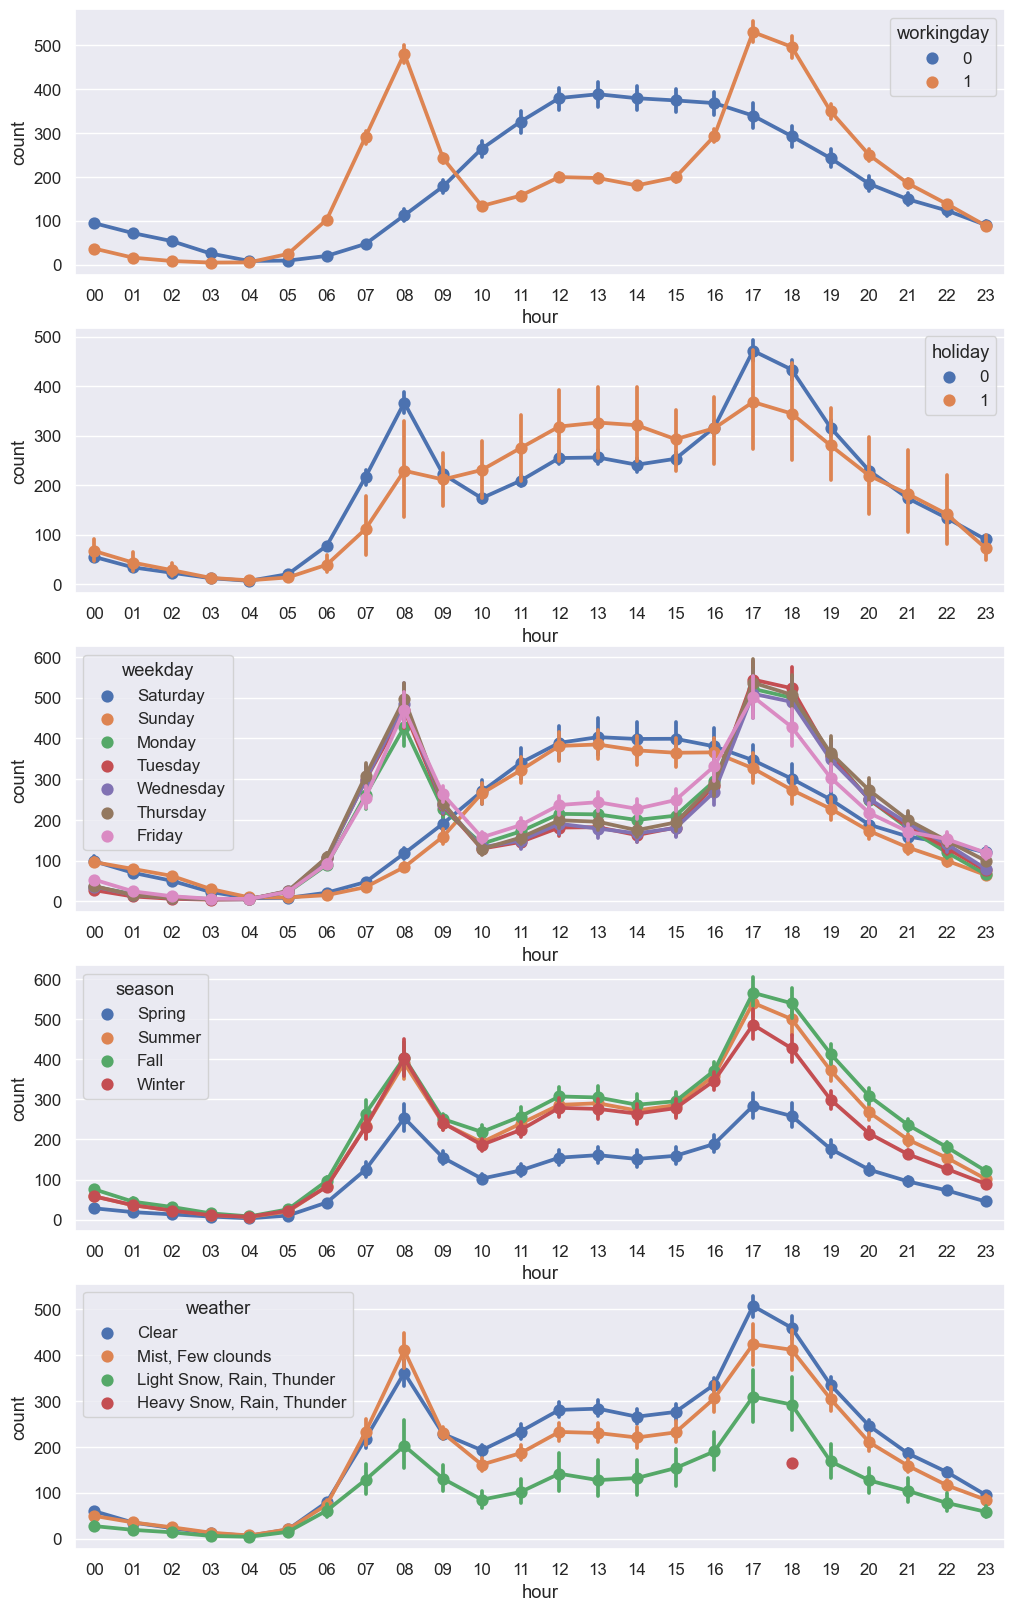

In [121]:
# 스텝 1 : m행 n열 Figure 준비
sns.set(font_scale = 1.1)
fig, axes = plt.subplots(nrows = 5) # 5행 1열
fig.set_size_inches(12, 20)

# 스텝 2 : 서브플롯 할당
# 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여 수량 포인트 플롯
sns.pointplot(x = "hour", y = "count", data = train_df, hue = "workingday", ax = axes[0])
sns.pointplot(x = "hour", y = "count", data = train_df, hue = "holiday", ax = axes[1])
sns.pointplot(x = "hour", y = "count", data = train_df, hue = "weekday", ax = axes[2])
sns.pointplot(x = "hour", y = "count", data = train_df, hue = "season", ax = axes[3])
sns.pointplot(x = "hour", y = "count", data = train_df, hue = "weather", ax = axes[4])

plt.show()

- 근무일에는 출퇴근 시간에 대여량이 많고 쉬는 날에는 오후 12시 ~ 2시에 대여량이 많음
- 공휴일, 요일에 따른 그래프도 근무일 여부에 따른 그래프와 유사함
- 가을에 가장 대여량이 많고 봄에 가장 적음
- 날씨가 좋을 때 가장 대여량이 많음
    - 폭우, 폭설이 내릴 때 저녁 6시에 대여건수가 있음

### 날씨 데이터 시각화

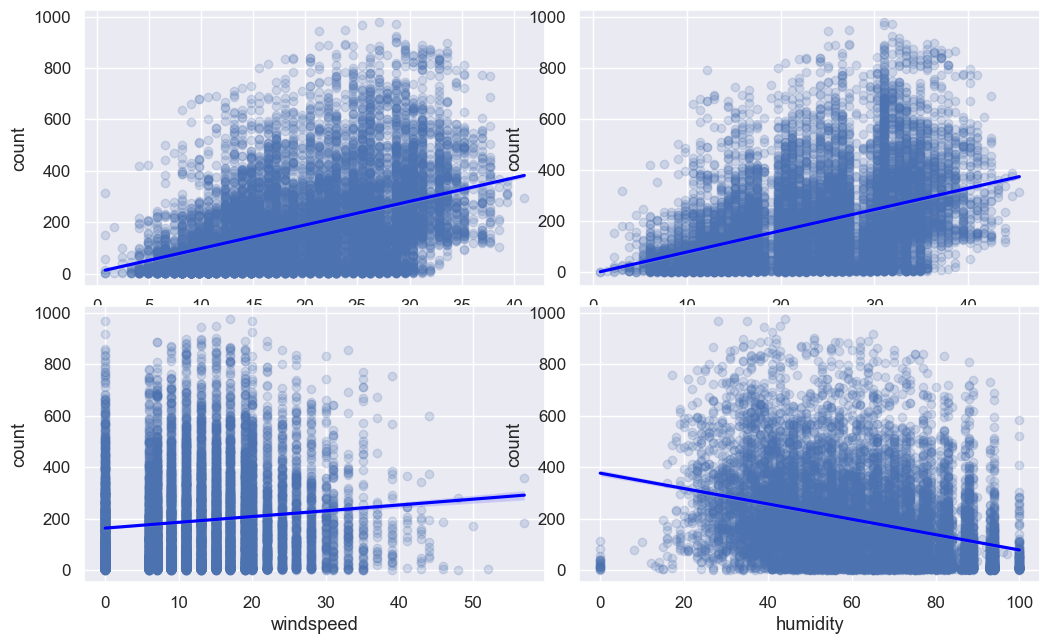

In [122]:
# 스텝1 : m 행 n 열 Figure 준비
sns.set(font_scale = 1.1)
fig, axes = plt.subplots(nrows = 2, ncols = 2) # 2행 2열 Figure 생성
plt.tight_layout() # 그래프 사이 여백 확보
fig.set_size_inches(10, 6)

# 스텝 2 : 서브플롯 할당
# 온도, 체감 온도, 풍속, 습도 별 대여 수량 산점도 그래프
sns.regplot(x = "temp", y = "count", data = train_df, ax = axes[0, 0], 
            scatter_kws = {"alpha": 0.2}, line_kws = {"color" : "blue"})
sns.regplot(x = "atemp", y = "count", data = train_df, ax = axes[0, 1], 
            scatter_kws = {"alpha": 0.2}, line_kws = {"color" : "blue"})
sns.regplot(x = "windspeed", y = "count", data = train_df, ax = axes[1, 0], 
            scatter_kws = {"alpha": 0.2}, line_kws = {"color" : "blue"})
sns.regplot(x = "humidity", y = "count", data = train_df, ax = axes[1, 1], 
            scatter_kws = {"alpha": 0.2}, line_kws = {"color" : "blue"})

plt.show()

- 실제 온도와 체감 온도가 높을수록 대여량이 많음
- 습도가 낮을수록 대여량이 많음
- 풍속은 셀수록 대여량이 많음
    - 풍속이 0인 데이터가 많고 풍속이 비어있는 구간이 있어 관측 오류가 의심됨
        - 이상값 대체를 하거나 컬럼 삭제를 고려해야함

### 히트맵

In [123]:
# 수치형 컬럼만 선택
corr_mat = train_df[["temp", "atemp", "humidity", "windspeed", "count"]].corr()
corr_mat

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.394454,0.389784,-0.317371,0.101369,1.000000


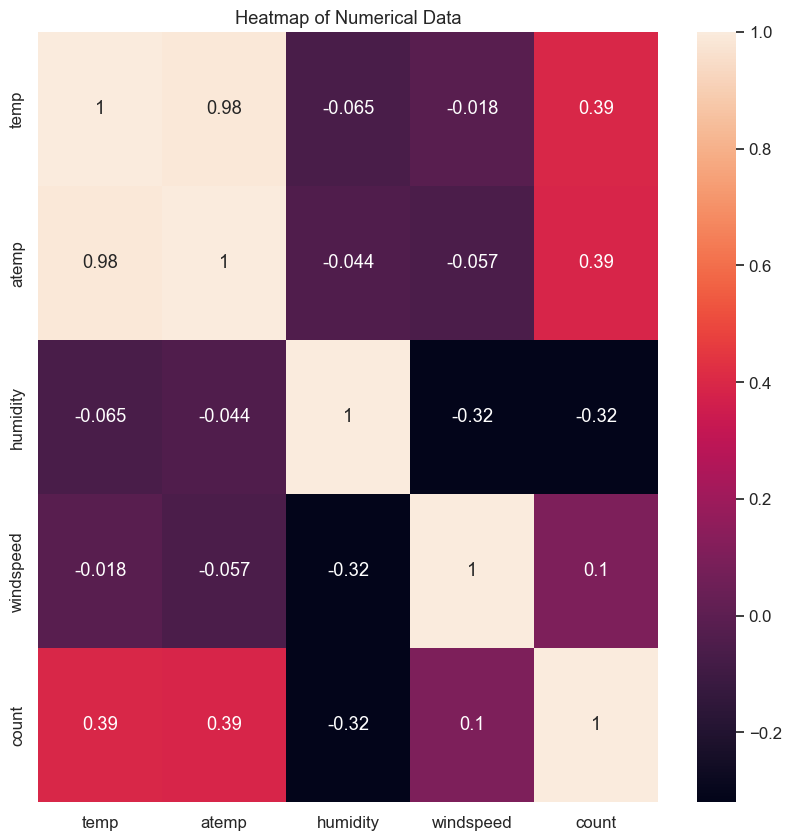

In [124]:
# 피처 간 상관관계 행렬
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

sns.heatmap(corr_mat, annot = True) # 상관관계 히트맵 그리기

ax.set(title = "Heatmap of Numerical Data")
plt.show()

- 풍속은 상관관계가 매우 약해서 모델 학습에 악영향을 줄 수 있음

## 정리

- 종속변수를 로그변환하여 정규분포에 가깝게 변환한 후 모델 학습
- datetime 컬럼은 여러 정보의 혼합체이기 때문에 각각 연도, 월, 일, 시간, 분, 초, 요일 컬럼으로 분리
    - datetime 은 인덱스 역할만 하기 때문에 삭제
    
- 테스트 데이터에는 없는 casual과 registered는 삭제

- date 컬럼이 제공하는 정보는 모두 year, month, day로 분리했기 때문에 삭제

- month 는 season의 세부 분류로 볼 수 있음
    - 데이터가 지나치게 세분화되면 분류별 데이터 수가 적어져 오히려 학습에 방해가 될 수 있어서 제거
    
- day는 분별력이 없어서 제거

- minute과 second는 아무런 정보가 없어서 제거

- weather가 4인 경우는 이상치 처리

- windspeed 컬럼은 결측값이 많고 대여량과의 관계가 매우 약해서 제거

## 모델링 전략

- 베이스라인 모델 : 가장 기본적인 선형회귀 모델
- 타깃값은 log(count) 사용


## 데이터 전처리

In [125]:
df_train = pd.read_csv("./data/bike/train.csv", parse_dates=['datetime'])
df_test = pd.read_csv("./data/bike/test.csv", parse_dates=['datetime'])
test = pd.read_csv("./data/bike/test.csv")

In [126]:
# 날씨 이상치 제거
train_df = train_df[train_df["weather"] != 4]

In [127]:
# train 데이터와 test 데이터를 합쳐서 전처리 후 종속변수가 null인 데이터와 아닌 데이터로 나누면 다시 train과 test로 나눠짐
all_df = pd.concat([train_df, test_df], ignore_index = True)
all_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3.0,13.0,16.0,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8.0,32.0,40.0,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5.0,27.0,32.0,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3.0,10.0,13.0,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0.0,1.0,1.0,2011-01-01,2011,01,01,04,00,00,Saturday


In [128]:
all_df.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17378,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
all_df["date"] = all_df["datetime"].map(lambda x: x.split()[0])
all_df["year"] = all_df["datetime"].map(lambda x: x.split()[0].split("-")[0])
all_df["month"] = all_df["datetime"].map(lambda x: x.split()[0].split("-")[1])
all_df["hour"] = all_df["datetime"].map(lambda x: x.split()[1].split(":")[0])
all_df["weekday"] = all_df["date"].map(lambda x: pd.to_datetime(x).weekday())

In [130]:
all_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3.0,13.0,16.0,2011-01-01,2011,01,01,00,00,00,5
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8.0,32.0,40.0,2011-01-01,2011,01,01,01,00,00,5
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5.0,27.0,32.0,2011-01-01,2011,01,01,02,00,00,5
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3.0,10.0,13.0,2011-01-01,2011,01,01,03,00,00,5
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0.0,1.0,1.0,2011-01-01,2011,01,01,04,00,00,5


### 변수 제거

In [131]:
drop_features = ["casual", "registered", "datetime", "date", "month", "windspeed", "day", "minute", "second"]
all_df = all_df.drop(drop_features, axis = 1)

In [132]:
all_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,hour,weekday
0,Spring,0,0,Clear,9.84,14.395,81,16.0,2011,00,5
1,Spring,0,0,Clear,9.02,13.635,80,40.0,2011,01,5
2,Spring,0,0,Clear,9.02,13.635,80,32.0,2011,02,5
3,Spring,0,0,Clear,9.84,14.395,75,13.0,2011,03,5
4,Spring,0,0,Clear,9.84,14.395,75,1.0,2011,04,5


### 데이터 분할

In [ ]:
~pd.isna(all_df["count"])

In [133]:
train = all_df[~pd.isna(all_df["count"])]
test = all_df[pd.isna(all_df["count"])]

In [134]:
x_train = train.drop("count", axis = 1)
x_test = test.drop("count", axis = 1)
y = train["count"]

In [135]:
x_train.shape, x_test.shape, y.shape

((10886, 10), (6493, 10), (10886,))

In [136]:
x_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,Spring,0,0,Clear,9.84,14.395,81,2011,00,5
1,Spring,0,0,Clear,9.02,13.635,80,2011,01,5
2,Spring,0,0,Clear,9.02,13.635,80,2011,02,5
3,Spring,0,0,Clear,9.84,14.395,75,2011,03,5
4,Spring,0,0,Clear,9.84,14.395,75,2011,04,5


In [137]:
x_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
10886,1,0,1,1,10.66,11.365,56,2011,00,3
10887,1,0,1,1,10.66,13.635,56,2011,01,3
10888,1,0,1,1,10.66,13.635,56,2011,02,3
10889,1,0,1,1,10.66,12.880,56,2011,03,3
10890,1,0,1,1,10.66,12.880,56,2011,04,3


# 베이스라인 모델

In [138]:
lr_l = LinearRegression()
log_y = np.log(y)
lr_l.fit(x_train, log_y)

ValueError: could not convert string to float: 'Spring'

In [ ]:
lr_n = LinearRegression()
lr_n.fit(x_train, y)

In [ ]:
pred_l = lr_l.predict(x_train)
pred_n = lr_n.predict(x_train)

In [ ]:
print(rmsle(log_y, pred_l, True))
print(rmsle(y, pred_n, False))

- log(count)로 예측한 모델이 더 성능이 좋은 것을 확인

In [ ]:
pred = lr_l.predict(x_test)
pred = np.exp(pred)
submission_df["count"] = pred
submission_df.to_csv("submission_baseline_test.csv", index = False)

In [ ]:
submission_df

## 릿지

In [ ]:
rid = Ridge(random_state = SEED)

In [ ]:
# 하이퍼파라미터 값 목록
ridge_params = {"alpha" : [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}

# 교차 검증용 평가 함수(RMSLE 점수 계산)
rmsle_scorer = make_scorer(rmsle, greater_is_better = False)

splitter = KFold(n_splits = 5, shuffle = True, random_state = SEED)

# 그리드 서치(with 릿지) 객체 생성
gs_rid = GridSearchCV(estimator = rid, # 릿지 모델
                     param_grid = ridge_params, # 값 목록
                     scoring = rmsle_scorer, # 평가지표
                     cv = splitter) # 교자검증 분할

In [ ]:
gs_rid.fit(x_train, log_y)

In [ ]:
gs_rid.best_params_

In [ ]:
gs_rid.best_score_

In [ ]:
preds = gs_rid.best_estimator_.predict(x_train)

In [ ]:
rmsle(log_y, preds, True)

In [ ]:
pred = gs_rid.best_estimator_.predict(x_test)
pred = np.exp(pred)
submission_df["count"] = pred
submission_df.to_csv("submission_ridge_test.csv", index = False)

# 라쏘

In [ ]:
las = Lasso(random_state = SEED)

In [ ]:
# 하이퍼 파라미터 값 목록
lasso_alpha = 1 / np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {"max_iter" : [3000], "alpha": lasso_alpha}

splitter = KFold(n_splits = 5, shuffle = True, random_state = SEED)

# 그리드 서치(with 라쏘) 객체 생성
gs_las = GridSearchCV(estimator = las,
                     param_grid = lasso_params,
                     scoring = rmsle_scorer,
                     cv = splitter)

In [ ]:
gs_las.fit(x_train, log_y)

In [ ]:
gs_las.best_params_

In [ ]:
gs_las.best_score_

In [ ]:
preds = gs_lass.best_estimator_.predict(x_train)
rmsle(log_y, preds, True)

# 랜덤포레스트

In [ ]:
rf = RandomForestRegressor(random_state = SEED)

In [ ]:
# 그리드 서치 객체 생성
rf_params = {"n_estimators" : [100, 120, 140, 160]}

splitter = KFold(n_splits = 5, shuffle = True, random_state = SEED)

gs_rf = GridSearchCV(estimator = rf,
                    param_grid = rf_params,
                    scoring = rmsle_scorer,
                    cv = splitter)

In [ ]:
gs_rf.fit(x_train, log_y)

In [ ]:
gs_rf.best_params_

In [ ]:
gs__rf.best_score_

In [ ]:
preds = gs_rf.best_estimator_.predcit(x_train)
rmsle(log_y, preds, True)

In [ ]:
pred = gs_rf.best_estimator_.predcit(x_test)
pred = np.exp(pred)
submission_df["count"]
submission_df.to_csv("submission_rf_test.csv", index = False)

## 추가 전처리

In [ ]:
x_train.head()

In [ ]:
gs_rf.best_estimator_.feature_importances_

In [ ]:
x_train.shape, train.shape

In [ ]:
all_df = pd.concat([train, test], ignore_index = True)
all_df

In [ ]:
# 계절, 공휴일 등 범주형 데이터를 원핫인코딩
all_ohe = pd.get_dummies(all_df, columns = ["season", "holiday", "workingday", "weather",
                                           "year", "hour", "weekday"])

In [ ]:
all_ohe.head()

In [ ]:
train_ohe = all_ohe[~pd.isna(all_df["count"])]
test_ohe = all_ohe[pd.isna(all_df["count"])]

In [ ]:
x_train_ohe = train_ohe.drop("count", axis = 1)
x_test_ohe = test_ohe.drop("count", axis = 1)

## 선형회귀 + 원핫인코딩

In [ ]:
lr_ohe = LinearRegression()
lr_ohe.fit(x_train_ohe, log_y)

In [ ]:
preds = lr_ohe.predict(x_train_ohe)
rmsle(log_y, preds, True)

## 릿지 + 원핫인코딩

In [ ]:
rid = Ridge(random_state = SEED)

In [ ]:
gs_rid = GridSearchCV(estimator = rid,
                     param_grid = ridge_params,
                     scoring = rmsle_scorer,
                     cv = splitter)

In [ ]:
gs_rid.fit(x_train_ohe, log_y)

In [ ]:
gs_rid.best_score_

In [ ]:
preds = gs_rid.predict(x_train_ohe)
rmsle(log_y, preds, True)

## 라쏘 + 원핫인코딩

In [ ]:
las = Lasso(random_state = SEED)

In [ ]:
gs_las = GridSearchCV(estimator = las,
                     param_grid = lasso_params,
                     scoring = rmsle_scorer,
                     cv = splitter)

In [ ]:
gs_las.fit(x_train_ohe, log_y)

In [ ]:
gs_las.best_score_

In [ ]:
preds = gs_lass.predict(x_train_ohe)
rmsle(log_y, preds, True)

## 랜덤포레스트 + 원핫인코딩

In [ ]:
rf = RandomForestRegressor(random_state = SEED)

In [ ]:
gs_rf = GridSearchCV(estimator = rf,
                    param_grid = rf_params,
                    scoring = rmsle_scorer,
                    cv = splitter)

In [ ]:
gs_rf.fit(x_train_ohe, log_y)

In [ ]:
gs_rf.best_score_

In [ ]:
preds = gs_rf.predict(x_train_ohe)
rmsle(log_y, preds, True)